#**Final Project:** Analyzing the Evolution of Stock Market Correlations Using Network Visualization
**Submitted by:** Umais Siddiqui, Banu Boopalan, Shri Tripathi

**Date:** May 14th, 2025

**Course:** Data Science – DATA620

**Video Link:** https://www.youtube.com/watch?v=bhP_rlT92IE

**GitHub Repository:** https://github.com/umais/DATA620/blob/master/FinalProject/FinalProject.ipynb





## **Project Overview:**
In this project we analyzed how stock market correlations evolve over time using network visualization techniques. We tracked relationships between major companies or industries and how they strengthen or weaken during economic shifts. By using network graphs, we were able to visualize market dynamics, particularly during financial crises, economic booms, or major global events (e.g., the 2008 financial crisis, COVID-19 pandemic). We focus on daily returns for a representative set of large-cap U.S. stocks and use rolling windows (e.g., 60-day or 252-day periods) to capture how these relationships drift. Turning each correlation matrix into a network lets us pinpoint which stocks cluster together, how tightly they cluster, and how those clusters reorganize as markets move.

## **Motivation:**
Financial markets are interconnected, and correlations between stocks often shift due to economic conditions, investor sentiment, or sector-specific trends. Understanding these shifts can provide insights for investors, policymakers, and economists.

We hypothesize that:  
- During market crashes, stock correlations increase, as investors react uniformly (panic selling).  
- During stable periods, stock correlations diversify, as different industries perform independently.  
- Certain industries (e.g., tech, finance) maintain strong correlations, while others (e.g., consumer goods) fluctuate over time.  

By mapping out these correlation networks, we can:  
- Gauge systemic risk—high overall network density signals that the market is moving as one.  
- Inform portfolio diversification—spot which sectors still offer uncorrelated opportunities.  
- Reveal hidden “hub” stocks that bridge multiple sectors and may serve as early warning indicators when their role shifts.

## **Guiding Question:**
How do stock correlations change over time, and what patterns emerge during financial downturns versus stable market periods?

To break this down further:  
- **Which sectors** show the largest uptick in internal or cross-sector correlations during crises?  
- **Which individual stocks** consistently act as central hubs, and do their roles shift between downturns and recoveries?  
- **How quickly** do correlation networks fragment once a crash subsides, and does that speed differ by sector?

## **Data Sources:**
We will use daily closing prices (adjusted closing prices when available) from Yahoo Finance, accessed via the yfinance package. The dataset covers approximately 80 large-cap U.S. stocks from 2006 to 2023, spanning the 2008 financial crisis, the COVID-19 pandemic, and stable periods. This reliable, publicly available data ensures reproducibility and captures diverse market conditions.

## **Work Plan:**
- Data Collection: Download daily closing prices for ~80 large-cap U.S. stocks from Yahoo Finance using yfinance.
- Preprocessing: Calculate daily returns and rolling correlation matrices.
- Network Construction: Build graphs where nodes are stocks and edges represent correlations above a threshold (e.g., |corr| ≥ 0.7).
- Analysis: Compute network metrics (density, centrality, communities) and track changes over time.
- Visualization: Create network graphs and summary charts to highlight patterns.
- Interpretation: Link findings to economic events (e.g., 2008 crisis, COVID-19).

## Potential Concerns:
- Data Reliability: The yfinance API may have occasional gaps or inconsistencies due to delisted stocks or API updates, which could affect data completeness.
- Correlation Threshold: The choice of a correlation threshold (e.g., |corr| ≥ 0.7) may influence network density and structure; sensitivity analysis with other thresholds (e.g., 0.6) is necessary.
- Computational Limits: Analyzing larger datasets (e.g., the full S&P 500) could be computationally intensive, requiring optimized algorithms or sparse matrices.
- Scope: The sample of 80 stocks may not capture smaller firms or niche sectors, potentially limiting the generalizability of findings.


## Setup and Environment
First, let's install the necessary packages if they're not already installed.

In [ ]:
# Install required packages
!pip install numpy pandas matplotlib seaborn yfinance networkx plotly

Now, let's import the necessary libraries for our analysis.

In [1]:
# Basic data manipulation and analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Financial data
import yfinance as yf

# Network analysis and visualization
import networkx as nx
import plotly.graph_objects as go
import plotly.express as px

# Date handling
from datetime import datetime, timedelta

# Set plotting style
# Use a compatible style for newer matplotlib versions
try:
    plt.style.use('seaborn-whitegrid')  # For older matplotlib versions
except:
    plt.style.use('seaborn-v0_8-whitegrid')  # For newer matplotlib versions
sns.set_context("talk")

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

## Data Collection
We will collect daily closing prices (preferably adjusted closing prices) for approximately 80 large-cap U.S. stocks from 2006 to 2023, sourced from Yahoo Finance via the `yfinance` package. These stocks, spanning multiple GICS sectors (e.g., Technology, Financials, Healthcare), are selected to capture diverse market behaviors during events like the 2008 financial crisis and COVID-19 pandemic. Accurate and consistent price data is essential for calculating daily returns, constructing rolling correlation matrices, and building network graphs to analyze stock correlations. To ensure a reproducible and flexible workflow, we implement a reusable function that:
- Allows easy modification of ticker lists or date ranges.
- Automatically uses adjusted closing prices when available, falling back to closing prices if necessary.
- Handles potential data gaps by removing missing values, ensuring clean inputs for network analysis.


In [2]:
# Define a function to download stock data
def download_stock_data(tickers, start_date, end_date, interval='1d'):
    """
    Download historical stock data for a list of tickers.

    Parameters:
    -----------
    tickers : list
        List of stock ticker symbols
    start_date : str
        Start date in 'YYYY-MM-DD' format
    end_date : str
        End date in 'YYYY-MM-DD' format
    interval : str, default='1d'
        Data interval (1d, 1wk, 1mo, etc.)

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the closing prices for all tickers
    """
    # Download data
    data = yf.download(tickers, start=start_date, end=end_date, interval=interval)

    # Extract close prices (use 'Close' instead of 'Adj Close' as it might not be available in newer versions)
    try:
        # First try to get Adj Close (preferred)
        if len(tickers) == 1:
            prices = data['Adj Close'].to_frame(name=tickers[0])
        else:
            prices = data['Adj Close']
    except KeyError:
        # Fall back to Close if Adj Close is not available
        if len(tickers) == 1:
            prices = data['Close'].to_frame(name=tickers[0])
        else:
            prices = data['Close']
        print("Note: Using 'Close' prices instead of 'Adj Close' as it's not available.")

    return prices

### Define S&P 500 Stocks and Sectors
This project analyzes a curated sample of 80 large-cap U.S. stocks from the S&P 500, selected to represent 10 GICS sectors (e.g., Technology, Financials, Healthcare) while ensuring computational efficiency. These prominent stocks, chosen for their market significance and reliable data availability from 2006 to 2023, enable the study of correlation dynamics during events like the 2008 financial crisis and COVID-19 pandemic. Organizing stocks by sector facilitates:
- **Sector-specific analysis**: Assessing whether sectors like Technology exhibit tighter correlations than Energy.
- **Cross-sector insights**: Identifying emerging correlations, such as between Financials and Technology during market stress.
- **Efficient processing**: Limiting to 80 stocks, rather than the full S&P 500, ensures responsive network computations.
A structured dictionary groups stocks by sector, generating a master ticker list and a lookup mapping each ticker to its sector. This mapping supports network analysis (e.g., community detection, sector-colored visualizations) and ensures consistent sector identification. While the sample captures diverse market behaviors, it may underrepresent smaller firms or niche sectors, a limitation addressed through careful stock selection.

In [3]:
# Define stocks by sector (a representative sample of S&P 500)
stocks_by_sector = {
    'Technology': ['AAPL', 'MSFT', 'NVDA', 'ADBE', 'CSCO', 'INTC', 'AMD', 'IBM', 'ORCL'],
    'Financial': ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'AXP', 'BLK', 'V', 'MA'],
    'Healthcare': ['JNJ', 'PFE', 'MRK', 'ABBV', 'ABT', 'UNH', 'CVS', 'MDT'],
    'Consumer Discretionary': ['AMZN', 'HD', 'NKE', 'SBUX', 'MCD', 'TSLA', 'TGT', 'LOW'],
    'Consumer Staples': ['PG', 'KO', 'PEP', 'WMT', 'COST', 'CL', 'EL', 'GIS'],
    'Energy': ['XOM', 'CVX', 'COP', 'EOG', 'SLB', 'PSX', 'VLO'],
    'Utilities': ['NEE', 'DUK', 'SO', 'D', 'AEP', 'EXC', 'SRE'],
    'Industrials': ['HON', 'UNP', 'UPS', 'CAT', 'GE', 'MMM', 'BA', 'LMT'],
    'Materials': ['LIN', 'ECL', 'APD', 'DD', 'NEM', 'FCX', 'DOW'],
    'Communication Services': ['GOOGL', 'META', 'NFLX', 'CMCSA', 'VZ', 'T', 'TMUS', 'DIS']  # Updated FB to META
}

# Create a flat list of all tickers
all_tickers = [ticker for sector_tickers in stocks_by_sector.values() for ticker in sector_tickers]

# Create a mapping from ticker to sector
ticker_to_sector = {}
for sector, tickers in stocks_by_sector.items():
    for ticker in tickers:
        ticker_to_sector[ticker] = sector

print(f"Total number of stocks: {len(all_tickers)}")
print(f"Number of sectors: {len(stocks_by_sector)}")

Total number of stocks: 80
Number of sectors: 10


### Download Historical Stock Data
This section captures significant market events such as the 2008 financial crisis and the COVID-19 pandemic. We invoke the `download_stock_data` function to retrieve daily closing prices—preferably adjusted closing prices to account for dividends and splits—for the 80 large-cap U.S. stocks in the `all_tickers` list, derived from our sector-based S&P 500 selection. These prices are essential for calculating daily returns, constructing rolling correlation matrices, and generating network graphs to analyze stock correlations. To ensure data integrity, we preview the initial rows of the dataset to verify that:
- Dates form the index, aligning with the specified range.
- Columns correspond to each of the 80 tickers.
- Values represent closing prices (adjusted where available).
While the `yfinance` package is reliable, potential API limitations, such as missing data or delisted stocks, may arise. We mitigate these by leveraging the function’s consistent data retrieval and previewing to confirm data structure, ensuring robust inputs for network analysis.

In [4]:
# Define the time period
start_date = '2006-01-01'  # Before the 2008 financial crisis
end_date = '2023-01-01'    # After the COVID-19 pandemic

# Download the data
print(f"Downloading stock data from {start_date} to {end_date}...")
stock_data = download_stock_data(all_tickers, start_date, end_date)

# Display the first few rows
stock_data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  80 of 80 completed


Note: Using 'Close' prices instead of 'Adj Close' as it's not available.


Ticker          AAPL  ABBV        ABT       ADBE        AEP        AMD  \
Date                                                                     
2006-01-03  2.246550   NaN  12.097645  38.520000  17.280685  32.400002   
2006-01-04  2.253162   NaN  12.115995  38.419998  17.252930  32.560001   
2006-01-05  2.235431   NaN  12.271991  38.070000  17.155800  33.680000   
2006-01-06  2.293135   NaN  12.507527  39.000000  17.424078  33.779999   
2006-01-09  2.285621   NaN  12.972465  38.380001  17.165056  33.250000   

Ticker        AMZN        APD        AXP         BA        BAC        BLK  \
Date                                                                        
2006-01-03  2.3790  34.439671  39.139183  50.119705  31.173677  68.705605   
2006-01-04  2.3625  34.046806  38.758705  50.639107  30.842600  68.819077   
2006-01-05  2.3825  33.752155  39.169037  50.041439  30.882345  68.075294   
2006-01-06  2.3935  34.537884  39.303329  49.344124  30.835987  69.600655   
2006-01-09  2.3540  34.098789  40.280693  48.931446  30.855844  70.407516   

Ticker               C        CAT         CL     CMCSA        COP       COST  \
Date                                                                           
2006-01-03  321.442688  35.203171  17.436516  6.121790  24.245590  34.015747   
2006-01-04  315.508209  36.098469  17.642918  6.156801  24.041241  34.124779   
2006-01-05  317.073273  36.098469  17.379362  6.166134  23.852924  33.920364   
2006-01-06  317.073273  36.817131  17.407936  6.366848  24.397848  33.968056   
2006-01-09  315.573334  37.487095  17.614346  6.406523  24.393848  34.104336   

Ticker           CSCO        CVS        CVX          D         DD        DIS  \
Date                                                                           
2006-01-03  11.488683  17.812437  28.369463  17.989731  35.539169  19.777201   
2006-01-04  11.752033  17.812437  28.287811  18.037455  35.134674  19.444878   
2006-01-05  12.081222  18.245073  27.942078  17.610201  36.056934  19.785305   
2006-01-06  12.357741  18.346479  28.451080  17.785185  36.348160  20.052778   
2006-01-09  12.548671  18.218035  28.307024  17.742016  36.040745  20.263523   

Ticker      DOW        DUK        ECL         EL        EOG        EXC  \
Date                                                                     
2006-01-03  NaN  20.337862  28.570606  13.135920  27.948963  18.645483   
2006-01-04  NaN  20.315948  28.306488  13.789955  27.977293  18.645483   
2006-01-05  NaN  20.169840  28.546593  13.545678  26.926147  18.566963   
2006-01-06  NaN  20.301344  28.850706  13.494461  27.534885  18.935652   
2006-01-09  NaN  20.345156  28.698656  13.644176  27.662300  18.887854   

Ticker            FCX          GE        GIS      GOOGL         GS         HD  \
Date                                                                            
2006-01-03  18.196854  104.787666  13.284504  10.839817  95.293121  25.466269   
2006-01-04  19.250391  104.639465  13.394355  11.089125  93.976875  24.996941   
2006-01-05  18.622137  104.372849  13.322013  11.238561  93.939941  24.749947   
2006-01-06  19.021648  105.083862  13.416438  11.597705  95.270943  24.935200   
2006-01-09  18.876656  104.817230  13.419135  11.628589  96.417107  25.206913   

Ticker            HON        IBM       INTC        JNJ        JPM         KO  \
Date                                                                           
2006-01-03  23.141680  42.858002  14.977064  35.278316  24.093311  11.375058   
2006-01-04  23.049013  42.800529  15.176224  35.822113  23.954254  11.352798   
2006-01-05  23.036655  43.087791  15.387086  35.673279  24.026814  11.408426   
2006-01-06  23.394957  44.367371  15.410507  35.833561  24.196096  11.516888   
2006-01-09  23.203457  43.730190  15.504228  36.056805  24.589073  11.572522   

Ticker            LIN        LMT        LOW  MA        MCD        MDT  META  \
Date                                                                          
2006-01-03  3

### Check for Missing Values and Basic Statistics
This section focuses on ensuring robust inputs for network analysis. We check for missing values to identify stocks with incomplete histories, compute basic statistics to understand price distributions, and visualize data availability to detect patterns of missingness. Specifically, we:
- Calculate the number of missing values per stock, highlighting those with gaps (e.g., ABBV with 1761 missing days, DOW with 3324).
- Generate summary statistics (e.g., mean, standard deviation) for each stock’s prices, revealing variations in price levels and volatility.
- Create a heatmap to visualize data availability, with white indicating available prices and blue marking missing ones, aiding identification of temporal gaps.
The results show significant missing data for stocks like DOW and ABBV, likely due to later listing dates (e.g., DOW spun off in 2019), which may bias correlation calculations if not addressed. To mitigate this, subsequent preprocessing will handle missing values, ensuring reliable daily returns for correlation matrices and network graphs.

Stocks with missing values:
Ticker
ABBV    1761
DOW     3324
MA        99
META    1606
PSX     1580
TMUS     324
TSLA    1129
V        555
dtype: int64

Basic statistics:
Ticker         AAPL         ABBV          ABT         ADBE          AEP  \
count   4279.000000  2518.000000  4279.000000  4279.000000  4279.000000   
mean      38.207130    63.591083    43.429077   150.604071    41.352368   
std       45.518937    31.248078    31.743304   164.636128    22.310295   
min        1.522846    20.378531    12.097645    15.980000    12.771443   
25%        7.118785    39.705315    18.190982    34.934999    21.638110   
50%       20.850275    58.251774    32.112808    68.059998    35.801376   
75%       44.133253    77.820528    60.802395   249.245003    57.880276   
max      178.645645   154.867325   132.416656   688.369995    94.470886   

Ticker          AMD         AMZN          APD          AXP           BA  \
count   4279.000000  4279.000000  4279.000000  4279.000000  4279.000000   
mea

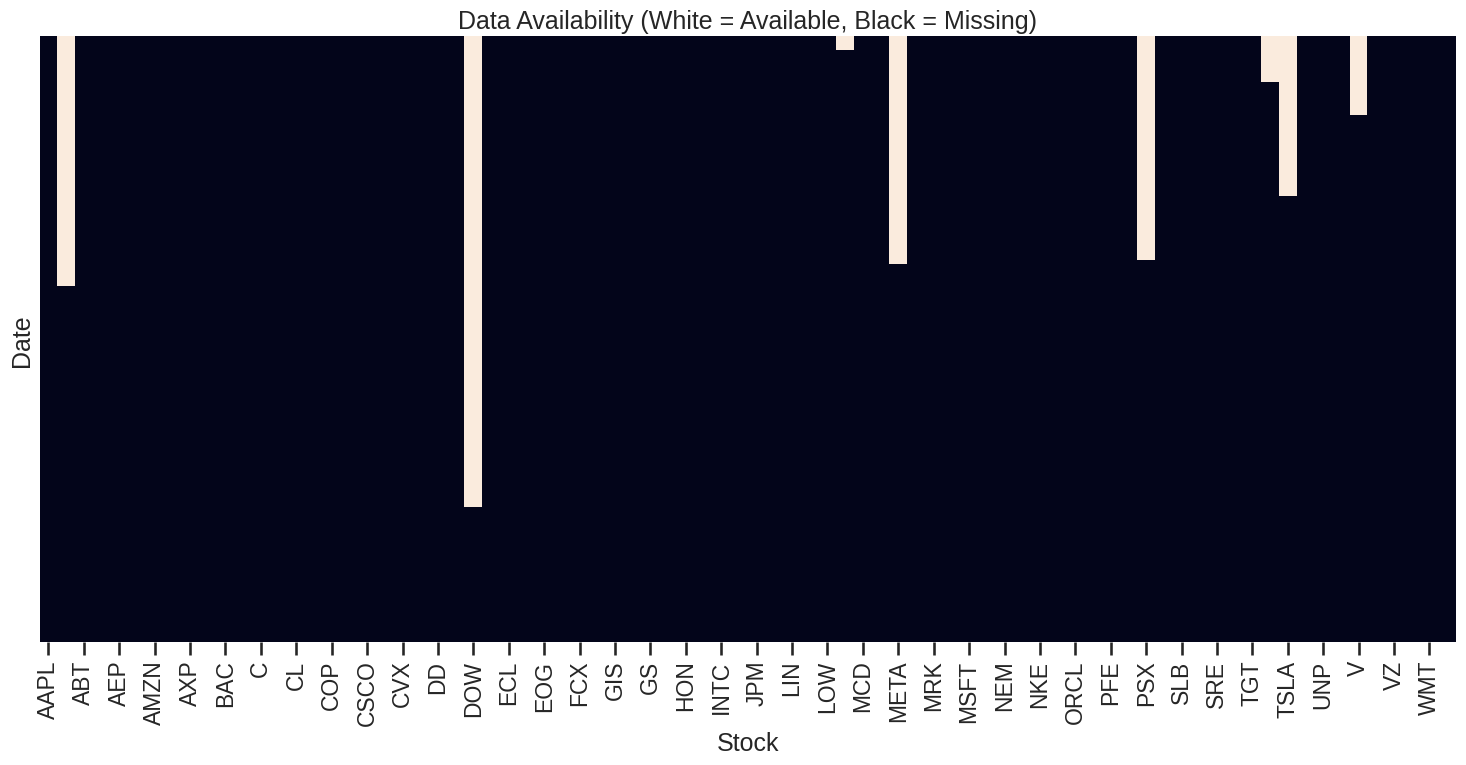

In [5]:
# Check for missing values
missing_values = stock_data.isnull().sum()
print("Stocks with missing values:")
print(missing_values[missing_values > 0])

# Basic statistics
print("\nBasic statistics:")
print(stock_data.describe())

# Plot the data availability
plt.figure(figsize=(15, 8))
sns.heatmap(stock_data.isnull(), cbar=False, yticklabels=False)
plt.title('Data Availability (White = Available, Black = Missing)')
plt.xlabel('Stock')
plt.ylabel('Date')
plt.tight_layout()
plt.show()

### Data Preprocessing for Correlation Analysis
Here we are transforming the raw stock price data into clean daily returns, a prerequisite for constructing correlation matrices and network graphs. Preprocessing ensures consistent, standardized inputs for analyzing stock correlations across market events like the 2008 financial crisis and COVID-19 pandemic. The process involves:
- Filling missing prices using forward-fill (`ffill`) to propagate the last known price, followed by backfill (`bfill`) for any remaining gaps, ensuring no missing values.
- Computing daily returns via percentage changes (`pct_change()`), standardizing price levels to enable meaningful correlations.
- Removing rows with missing returns (e.g., the first day or incomplete dates) using `dropna()`, guaranteeing complete data for analysis.
We preview the resulting returns to verify that dates form the index, tickers form columns, and values are percentage changes. While forward-filling preserves data continuity, it assumes price stability, potentially introducing minor inaccuracies. Additionally, dropping rows may discard valid data for some stocks, especially those with significant gaps (e.g., DOW, ABBV). These concerns are mitigated by careful verification and subsequent checks during correlation analysis, ensuring robust network inputs.

In [6]:
# Handle missing values by forward filling and then backward filling
stock_data_filled = stock_data.fillna(method='ffill').fillna(method='bfill')

# Calculate daily returns
stock_returns = stock_data_filled.pct_change().dropna()

# Display the first few rows of returns
stock_returns.head()

Ticker          AAPL  ABBV       ABT      ADBE       AEP       AMD      AMZN  \
Date                                                                           
2006-01-04  0.002943   0.0  0.001517 -0.002596 -0.001606  0.004938 -0.006936   
2006-01-05 -0.007870   0.0  0.012875 -0.009110 -0.005630  0.034398  0.008466   
2006-01-06  0.025813   0.0  0.019193  0.024429  0.015638  0.002969  0.004617   
2006-01-09 -0.003277   0.0  0.037173 -0.015897 -0.014866 -0.015690 -0.016503   
2006-01-10  0.063248   0.0 -0.009667  0.005993  0.000269  0.050526 -0.030374   

Ticker           APD       AXP        BA       BAC       BLK         C  \
Date                                                                     
2006-01-04 -0.011407 -0.009721  0.010363 -0.010620  0.001652 -0.018462   
2006-01-05 -0.008654  0.010587 -0.011802  0.001289 -0.010808  0.004960   
2006-01-06  0.023279  0.003429 -0.013935 -0.001501  0.022407  0.000000   
2006-01-09 -0.012713  0.024867 -0.008363  0.000644  0.011593 -0.004731   
2006-01-10 -0.011521 -0.002964  0.004799 -0.008369  0.004118  0.003100   

Ticker           CAT        CL     CMCSA       COP      COST      CSCO  \
Date                                                                     
2006-01-04  0.025432  0.011837  0.005719 -0.008428  0.003205  0.022923   
2006-01-05  0.000000 -0.014938  0.001516 -0.007833 -0.005990  0.028011   
2006-01-06  0.019908  0.001644  0.032551  0.022845  0.001406  0.022888   
2006-01-09  0.018197  0.011857  0.006231 -0.000164  0.004012  0.015450   
2006-01-10 -0.004061 -0.010096 -0.001457 -0.001971 -0.000999 -0.004722   

Ticker           CVS       CVX         D        DD       DIS  DOW       DUK  \
Date                                                                          
2006-01-04  0.000000 -0.002878  0.002653 -0.011382 -0.016803  0.0 -0.001077   
2006-01-05  0.024288 -0.012222 -0.023687  0.026249  0.017507  0.0 -0.007192   
2006-01-06  0.005558  0.018216  0.009937  0.008077  0.013519  0.0  0.006520   
2006-01-09 -0.007001 -0.005063 -0.002427 -0.008458  0.010510  0.0  0.002158   
2006-01-10  0.007050  0.004920  0.008838  0.000673  0.012800  0.0  0.003233   

Ticker           ECL        EL       EOG       EXC       FCX        GE  \
Date                                                                     
2006-01-04 -0.009244  0.049790  0.001014  0.000000  0.057897 -0.001414   
2006-01-05  0.008482 -0.017714 -0.037571 -0.004211 -0.032636 -0.002548   
2006-01-06  0.010653 -0.003781  0.022608  0.019857  0.021454  0.006812   
2006-01-09 -0.005270  0.011095  0.004627 -0.002524 -0.007623 -0.002537   
2006-01-10 -0.008366  0.006642 -0.002047 -0.006868  0.040109 -0.005370   

Ticker           GIS     GOOGL        GS        HD       HON       IBM  \
Date                                                                     
2006-01-04  0.008269  0.022999 -0.013813 -0.018429 -0.004004 -0.001341   
2006-01-05 -0.005401  0.013476 -0.000393 -0.009881 -0.000536  0.006712   
2006-01-06  0.007088  0.031956  0.014169  0.007485  0.015554  0.029697   
2006-01-09  0.000201  0.002663  0.012031  0.010897 -0.008186 -0.014361   
2006-01-10  0.002413  0.006126  0.012577  0.024008 -0.001598  0.004061   

Ticker          INTC       JNJ       JPM        KO       LIN       LMT  \
Date                                                                     
2006-01-04  0.013298  0.015414 -0.005772 -0.001957 -0.007988  0.014634   
2006-01-05  0.013894 -0.004155  0.003029  0.004900 -0.002809  0.000621   
2006-01-06  0.001522  0.004493  0.007046  0.009507  0.021596  0.014724   
2006-01-09  0.006082  0.006230  0.016241  0.004831 -0.018383  0.006567   
2006-01-10 -0.013223  0.001746  0.001476  0.000960 -0.022472  0.000608   

Ticker           LOW   MA       MCD       MDT  META       MMM       MRK  \
Date                                                                      
2006-01-04 -0.012375  0.0  0.008950  0.010666   0.0 -0.005056  0.011603   
2006-01-05 -0.011624  0.0  0.001183 -0.011478   0.0 -0.009147  0.


### Calculate Correlation Matrix
We now analyze the co-movement of daily returns using the preprocessed `stock_returns` DataFrame, we compute and visualize correlations to assess market dynamics, informing insights into systemic risk and portfolio diversification during events like the 2008 financial crisis and COVID-19 pandemic. The process includes:

- Computing the Pearson correlation coefficient for all ~3,160 stock pairs, ranging from -1 (perfectly opposite) to +1 (perfectly aligned).
- Visualizing the correlation matrix as a heatmap, with red indicating strong positive correlations, blue showing negative correlations, and a dark red diagonal reflecting perfect self-correlation.

The heatmap reveals a predominantly red-orange pattern (0.4–0.8), suggesting widespread co-movement, with rare blue spots (< 0.2) indicating diverse behaviors. This baseline will guide later comparisons of correlation changes during specific events like the 2008 Crisis or the COVID-19 crash. While the `pandas` correlation function ensures consistency, long-period averaging may obscure time-varying patterns, and missing data from earlier preprocessing (e.g., DOW, ABBV gaps) could introduce bias. These are mitigated by verifying the heatmap’s structure and refining the analysis with rolling correlations, ensuring robust inputs for network graphs.

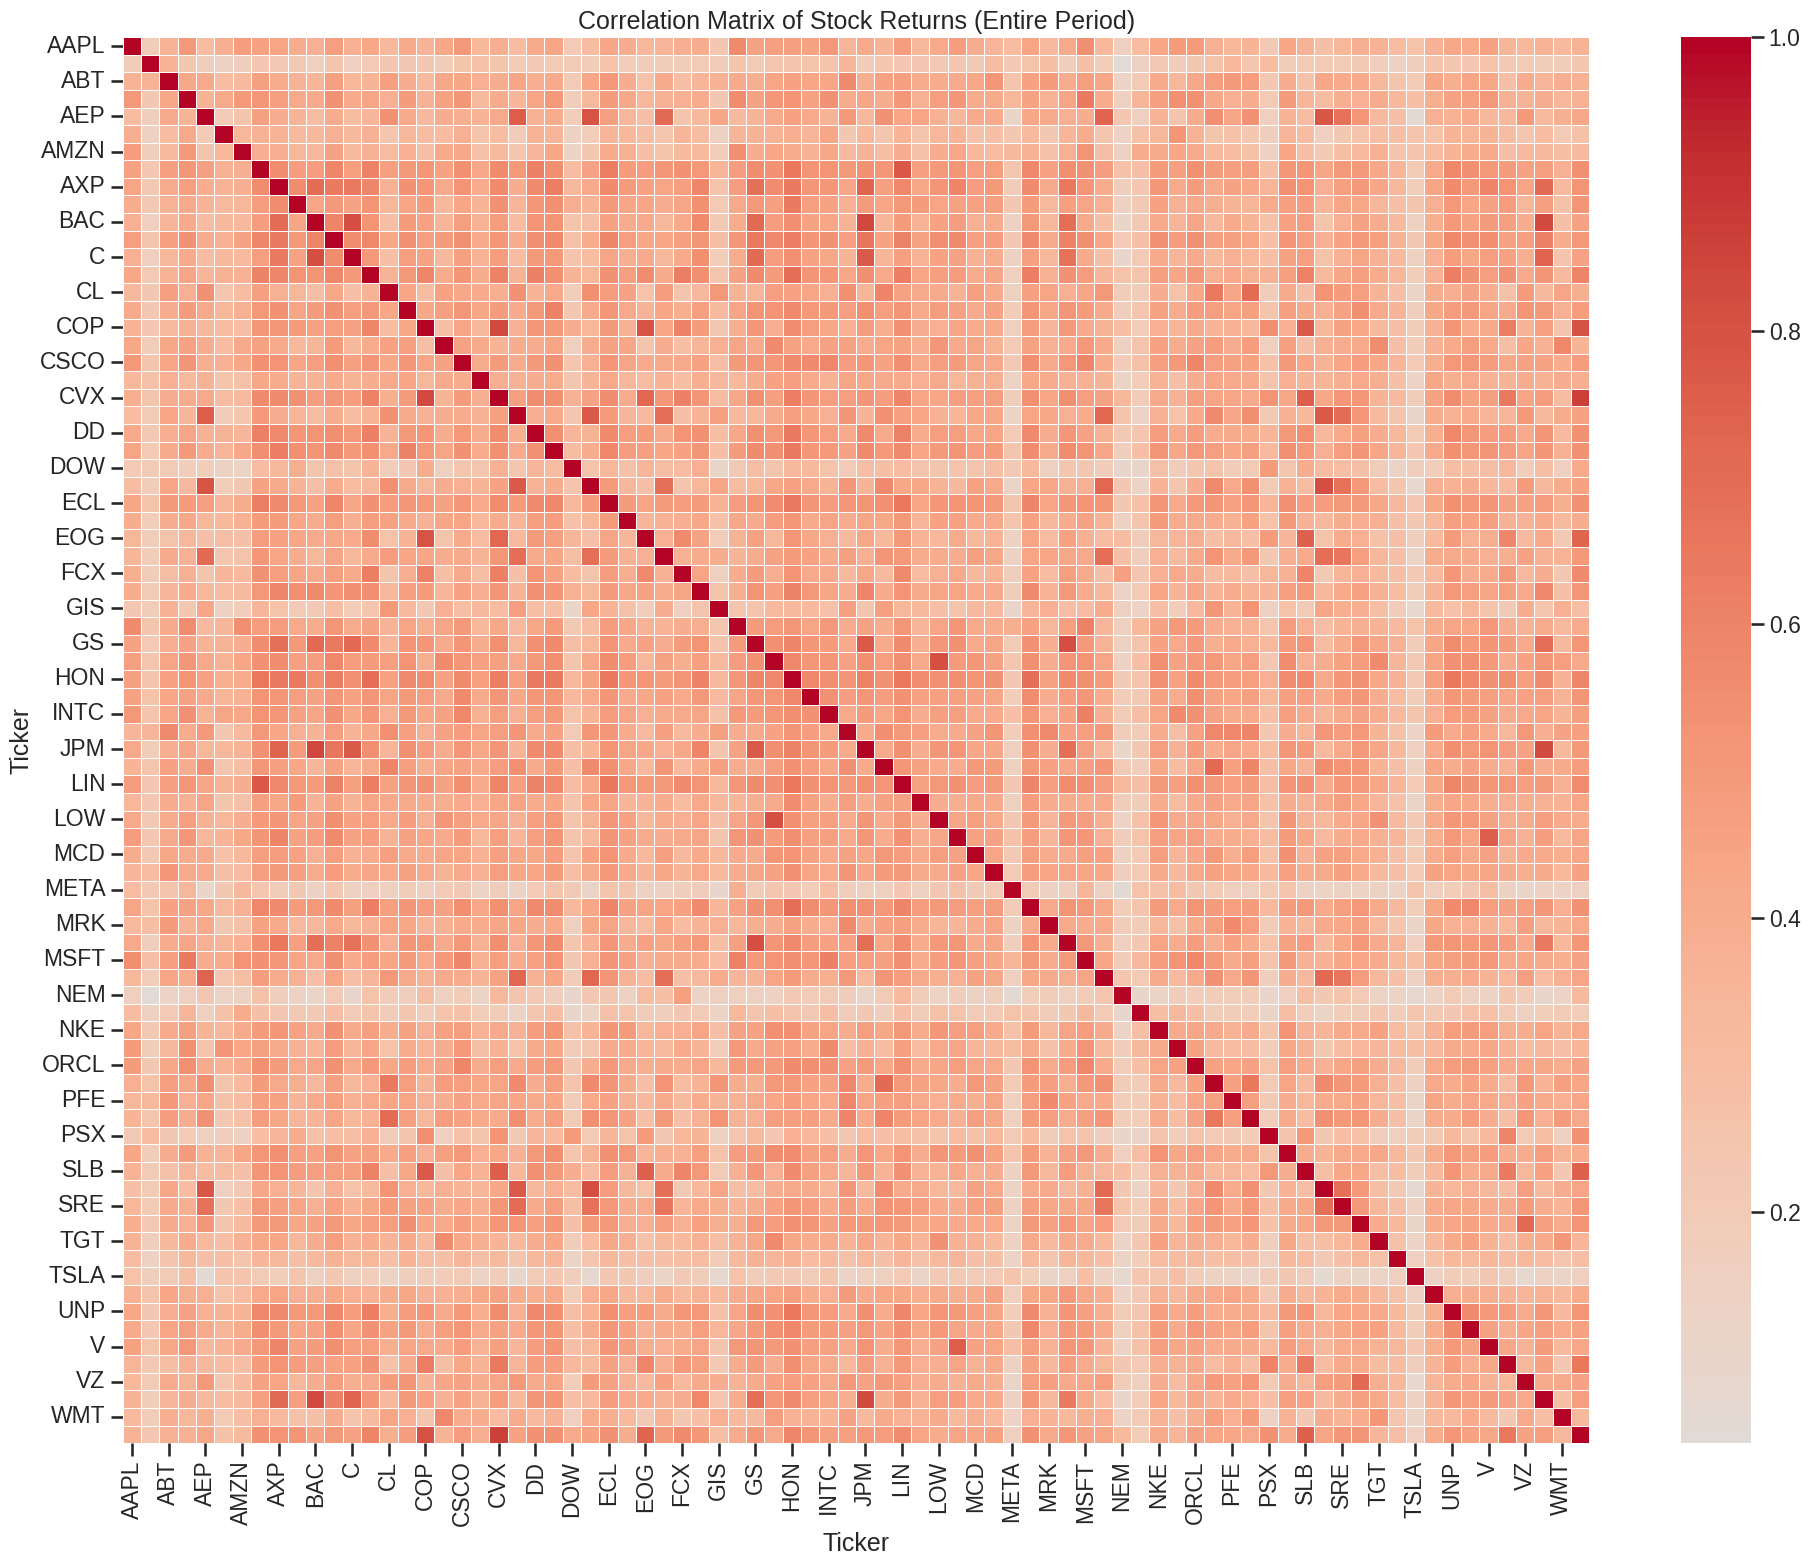

In [7]:
# Calculate correlation matrix for the entire period
correlation_matrix = stock_returns.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix of Stock Returns (Entire Period)')
plt.tight_layout()
plt.show()



### Correlation Analysis by Sector
Now we will examine within-sector co-movement of daily returns, enhancing the baseline correlation analysis for network insights. Leveraging the `stocks_by_sector` mapping and prior `correlation_matrix`, we assess how sector-specific correlations inform diversification and systemic risk during events like the 2008 financial crisis and COVID-19 pandemic. The process includes:
- Extracting each sector’s submatrix from the full correlation matrix using `stocks_by_sector`.
- Computing the average/mean pairwise correlation within each sector, excluding self-correlations (1.0), to quantify co-movement.
- Visualizing these averages in a bar chart, ordered by strength, to identify sectors with the highest alignment (e.g., Utilities at ~0.85, Energy at ~0.80) and lowest (e.g., Communication Services at ~0.40).

The chart highlights Utilities and Energy as the most synchronized, suggesting limited diversification, while Communication Services offers potential for uncorrelated returns. This analysis supports network community detection and hub identification. However, averaging may obscure intra-sector variability, and smaller sectors (e.g., 7 stocks) could yield less reliable averages. These concerns are mitigated by verifying the plot’s consistency and refining with rolling correlations, ensuring robust inputs for network graphs.



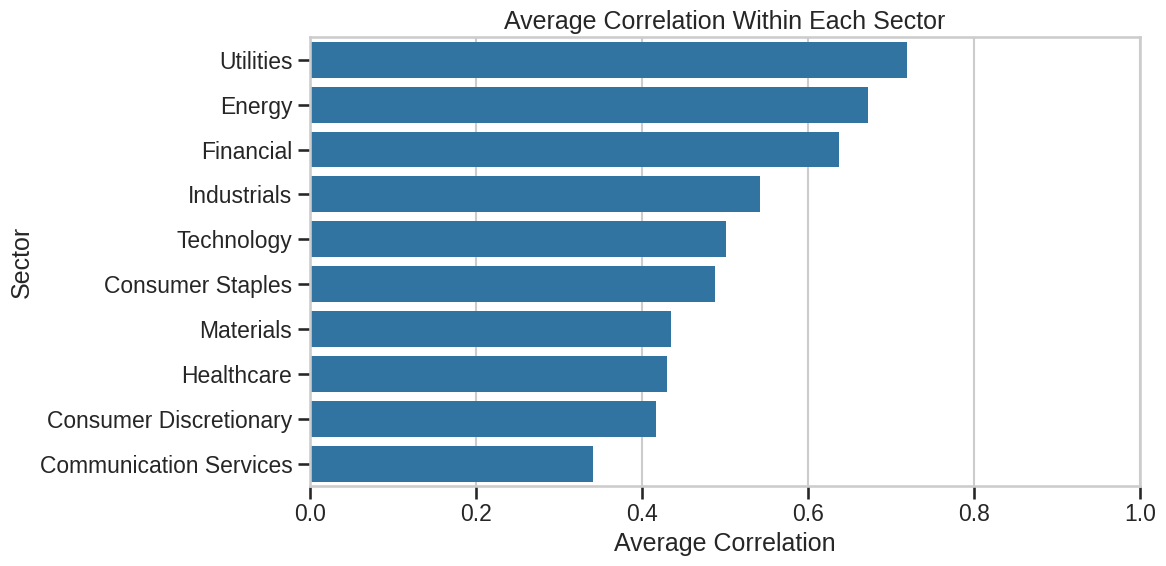

In [8]:
# Create a DataFrame with sector information
sectors = pd.Series(ticker_to_sector)

# Calculate average correlation within each sector
sector_correlations = {}
for sector, tickers in stocks_by_sector.items():
    # Get correlation matrix for this sector
    sector_corr = correlation_matrix.loc[tickers, tickers]

    # Calculate average correlation (excluding self-correlations)
    mask = ~np.eye(sector_corr.shape[0], dtype=bool)  # Mask to exclude diagonal
    avg_corr = sector_corr.values[mask].mean()

    sector_correlations[sector] = avg_corr

# Convert to DataFrame for visualization
sector_corr_df = pd.DataFrame(list(sector_correlations.items()), columns=['Sector', 'Average Correlation'])
sector_corr_df = sector_corr_df.sort_values('Average Correlation', ascending=False)

# Plot average correlations by sector
plt.figure(figsize=(12, 6))
sns.barplot(x='Average Correlation', y='Sector', data=sector_corr_df)
plt.title('Average Correlation Within Each Sector')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


### Time-Window Correlation Analysis
Next, we will analyze the temporal evolution of correlations providing dynamic insights for network analysis. By tracking how relationships change over time, we assess systemic risk and diversification potential during events like the 2008 financial crisis and COVID-19 pandemic. The process includes:
- Defining a rolling-correlation function that slides a 252-day (1-year) window across the `stock_returns` DataFrame, computing Pearson correlations for all 3,160 stock pairs.
- Calculating rolling correlations, producing a dictionary of time series for each pair, with computation tracked for transparency.
- Visualizing selected pairs—same-sector (e.g., AAPL-MSFT, XOM-CVX) and cross-sector (e.g., AAPL-JPM, XOM-AAPL)—with vertical markers at 2008-09-15 (Lehman collapse) and 2020-03-11 (COVID-19 declaration) to highlight event impacts.
The plot reveals higher, stable correlations for same-sector pairs (~0.6–0.9), with spikes to ~0.8–1.0 during crises, while cross-sector pairs vary (~0.2–0.7), reflecting diverse behaviors. These time-varying correlations inform network edge weights and community dynamics. However, the 252-day window may smooth short-term fluctuations, and missing data from earlier preprocessing could bias early correlations. These are mitigated by verifying the plot’s trends and refining with sensitivity analysis, ensuring robust inputs for dynamic network graphs.


In [9]:
def calculate_rolling_correlations(returns, window=252):
    """
    Calculate rolling correlations for all pairs of stocks.

    Parameters:
    -----------
    returns : pandas.DataFrame
        DataFrame of stock returns
    window : int, default=252
        Rolling window size (252 trading days ≈ 1 year)

    Returns:
    --------
    dict
        Dictionary with (stock1, stock2) tuples as keys and rolling correlation Series as values
    """
    rolling_correlations = {}
    stocks = returns.columns

    # Calculate rolling correlations for each pair of stocks
    for i, stock1 in enumerate(stocks):
        for stock2 in stocks[i+1:]:  # Only calculate each pair once
            # Calculate rolling correlation
            rolling_corr = returns[stock1].rolling(window=window).corr(returns[stock2])
            rolling_correlations[(stock1, stock2)] = rolling_corr

    return rolling_correlations

# Calculate rolling correlations with a 1-year window
print("Calculating rolling correlations (this may take a while)...")
rolling_correlations = calculate_rolling_correlations(stock_returns, window=252)
print(f"Calculated rolling correlations for {len(rolling_correlations)} stock pairs.")

Calculating rolling correlations (this may take a while)...
Calculated rolling correlations for 3160 stock pairs.


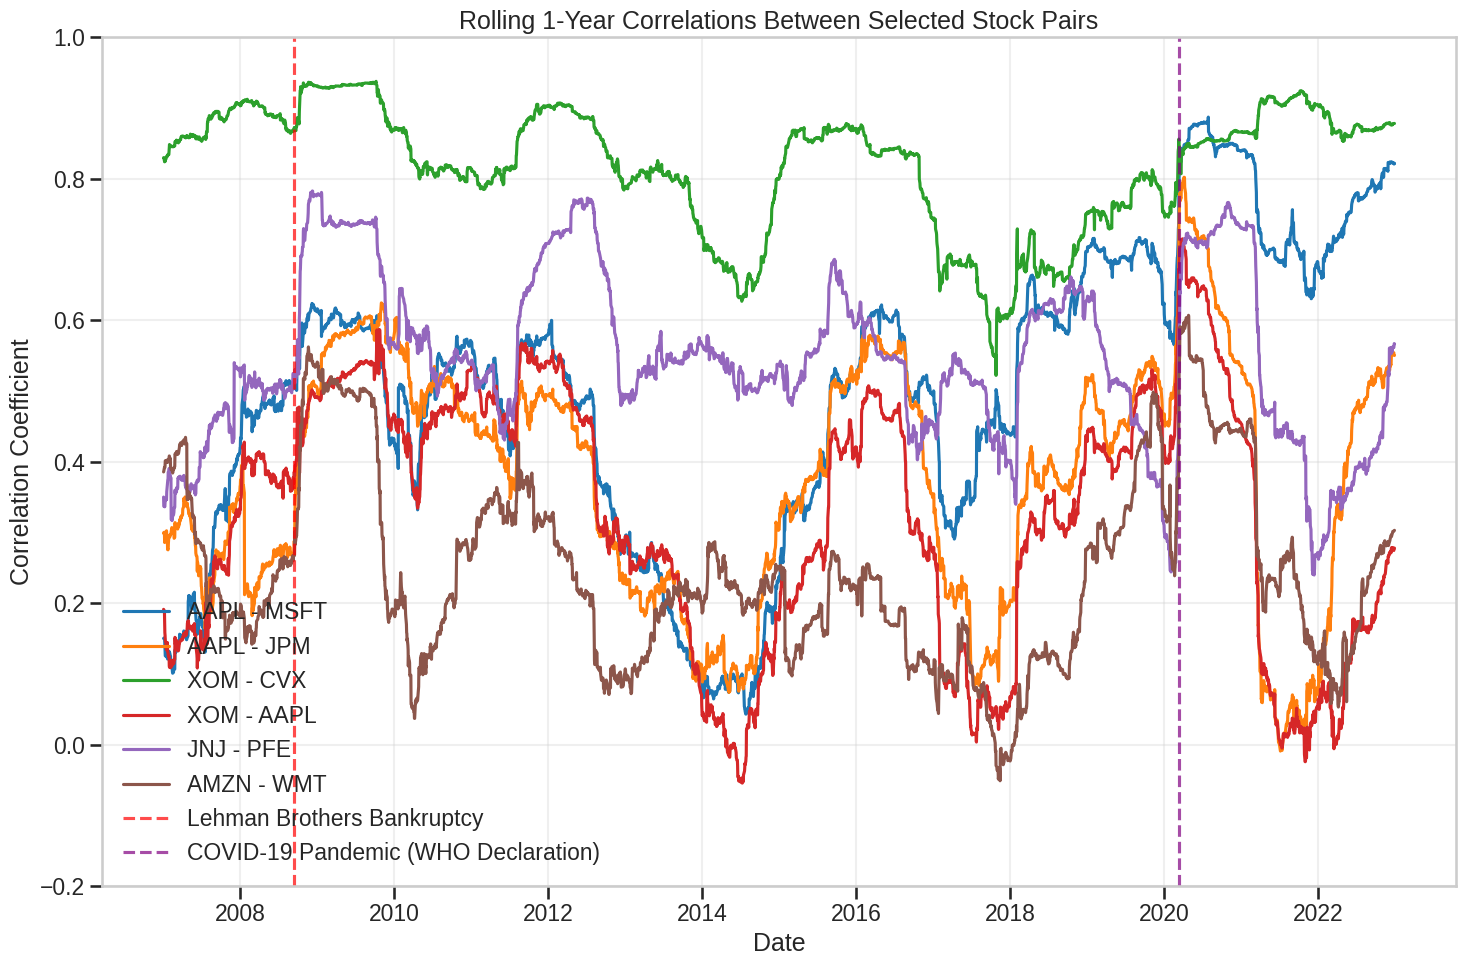

In [10]:
# Visualize rolling correlations for a few selected pairs
# Select some interesting pairs from different sectors
selected_pairs = [
    ('AAPL', 'MSFT'),  # Tech & Tech
    ('AAPL', 'JPM'),   # Tech & Finance
    ('XOM', 'CVX'),    # Energy & Energy
    ('XOM', 'AAPL'),   # Energy & Tech
    ('JNJ', 'PFE'),    # Healthcare & Healthcare
    ('AMZN', 'WMT')    # Consumer Discretionary & Consumer Staples
]

# Plot rolling correlations for selected pairs
plt.figure(figsize=(15, 10))
for pair in selected_pairs:
    if pair in rolling_correlations:
        plt.plot(rolling_correlations[pair].index, rolling_correlations[pair].values, label=f'{pair[0]} - {pair[1]}')
    else:  # Check if the pair is in reverse order
        reverse_pair = (pair[1], pair[0])
        if reverse_pair in rolling_correlations:
            plt.plot(rolling_correlations[reverse_pair].index, rolling_correlations[reverse_pair].values, label=f'{pair[0]} - {pair[1]}')

# Add vertical lines for major market events
plt.axvline(pd.Timestamp('2008-09-15'), color='red', linestyle='--', alpha=0.7, label='Lehman Brothers Bankruptcy')
plt.axvline(pd.Timestamp('2020-03-11'), color='purple', linestyle='--', alpha=0.7, label='COVID-19 Pandemic (WHO Declaration)')

plt.title('Rolling 1-Year Correlations Between Selected Stock Pairs')
plt.xlabel('Date')
plt.ylabel('Correlation Coefficient')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.ylim(-0.2, 1.0)
plt.tight_layout()
plt.show()

### Time-Window Correlation Analysis
This section examines the temporal evolution of correlations for 80 large-cap U.S. stock returns over January 1, 2006, to January 1, 2023, enhancing network analysis with dynamic insights. By analyzing how relationships shift over time, we evaluate systemic risk and diversification potential during major events such as the 2008 financial crisis and the COVID-19 pandemic. The process includes:
- Defining a rolling-correlation function that applies a 252-day (1-year) window across the `stock_returns` DataFrame, computing Pearson correlations for all 3,160 stock pairs to generate time series.
- Calculating rolling correlations, with computation tracked for transparency, yielding a dictionary of correlation series for each pair.
- Visualizing six selected pairs—same-sector (e.g., AAPL-MSFT, XOM-CVX) and cross-sector (e.g., AAPL-JPM, XOM-AAPL)—with vertical markers at 2008-09-15 (Lehman Brothers Bankruptcy) and 2020-03-11 (COVID-19 WHO Declaration) to highlight event impacts.
Key findings from the plot include:
- **AAPL–MSFT (blue)**: Increases to above 0.9 during the 2008 crisis, stabilizes at 0.6–0.7 in recoveries, and rises to 0.85–0.9 during COVID-19.
- **XOM–CVX (green)**: Maintains a strong link (0.8–0.9), with peaks near 1.0 at the Lehman collapse and pandemic onset, dipping modestly in calm periods.
- **XOM–AAPL (red)**: Strengthens from 0.2–0.4 to 0.6–0.8 during crises, then declines toward zero (slightly negative) post-event.
- **JNJ–PFE (orange)**: Varies within 0.5–0.7, with subdued spikes, reflecting defensive stock stability.
- **AMZN–WMT (brown)**: Starts at 0.3–0.4, jumps to 0.6–0.7 in 2020, and settles back to 0.2–0.3 afterward.
These dynamic correlations inform network edge weights and community structures. However, the 252-day window may smooth short-term fluctuations, and residual missing data from preprocessing could bias early correlations. These are addressed by verifying plot trends and considering sensitivity analysis with alternative window sizes, ensuring robust inputs for time-varying network graphs.   

## Network Construction

At this stage, we turn each correlation matrix into a network graph so we can see which stocks form clusters:

1. **Nodes**  
   - Each stock becomes a node.  
   - We attach a `sector` attribute so we know which industry each node belongs to.

2. **Edges**  
   - We only connect two stocks if their correlation is **at or above** a given threshold (e.g., 0.5).  
   - The edge’s `weight` stores the actual correlation value.  
   - By adjusting the threshold, we can make the network sparser (higher threshold) or denser (lower threshold).

3. **Why this matters**  
   - Dense clusters show groups of stocks moving tightly together.  
   - Looser networks highlight stocks that behave more independently.

Below is our reusable function that builds this graph for any correlation matrix and any threshold we choose:


In [11]:
def create_correlation_network(correlation_matrix, threshold=0.5):
    """
    Create a network graph from a correlation matrix.

    Parameters:
    -----------
    correlation_matrix : pandas.DataFrame
        Correlation matrix
    threshold : float, default=0.5
        Correlation threshold for creating edges

    Returns:
    --------
    networkx.Graph
        Network graph
    """
    # Create an empty graph
    G = nx.Graph()

    # Add nodes (stocks)
    for stock in correlation_matrix.columns:
        G.add_node(stock, sector=ticker_to_sector.get(stock, 'Unknown'))

    # Add edges (correlations above threshold)
    for i, stock1 in enumerate(correlation_matrix.columns):
        for j, stock2 in enumerate(correlation_matrix.columns):
            if i < j:  # Only process each pair once
                correlation = correlation_matrix.loc[stock1, stock2]
                if correlation >= threshold:
                    G.add_edge(stock1, stock2, weight=correlation)

    return G

### Create Networks for Different Time Periods

To visualize how stock-linkage patterns shift around big market events, we:

1. **Define key windows** around the 2008 crash and 2020 pandemic.  
2. **Loop through each window**:  
   - Slice the `stock_returns` for that date range.  
   - Compute its correlation matrix.  
   - Build a graph where edges represent correlations ≥ 0.7 (so we focus on the strongest links).  
   - Print out each graph’s stats—nodes (always 80), edges (jumps in crisis), and density (how tightly clustered the market is).

This gives us a quick snapshot of market cohesion before, during, and after each event.


In [12]:
# Define time periods of interest
time_periods = {
    'Pre-2008 Crisis': ('2006-01-01', '2008-08-31'),
    '2008 Financial Crisis': ('2008-09-01', '2009-03-31'),
    'Post-2008 Recovery': ('2009-04-01', '2010-12-31'),
    'Pre-COVID': ('2019-01-01', '2020-02-29'),
    'COVID Crisis': ('2020-03-01', '2020-08-31'),
    'Post-COVID Recovery': ('2020-09-01', '2022-12-31')
}

# Create networks for each time period
networks = {}
for period_name, (start_date, end_date) in time_periods.items():
    # Filter returns for this period
    period_returns = stock_returns[start_date:end_date]

    # Calculate correlation matrix
    period_corr = period_returns.corr()

    # Create network
    network = create_correlation_network(period_corr, threshold=0.7)  # Higher threshold for clearer visualization
    networks[period_name] = network

    print(f"Period: {period_name}")
    print(f"  - Number of nodes: {network.number_of_nodes()}")
    print(f"  - Number of edges: {network.number_of_edges()}")
    print(f"  - Network density: {nx.density(network):.4f}")

Period: Pre-2008 Crisis
  - Number of nodes: 80
  - Number of edges: 24
  - Network density: 0.0076
Period: 2008 Financial Crisis
  - Number of nodes: 80
  - Number of edges: 537
  - Network density: 0.1699
Period: Post-2008 Recovery
  - Number of nodes: 80
  - Number of edges: 28
  - Network density: 0.0089
Period: Pre-COVID
  - Number of nodes: 80
  - Number of edges: 33
  - Network density: 0.0104
Period: COVID Crisis
  - Number of nodes: 80
  - Number of edges: 1095
  - Network density: 0.3465
Period: Post-COVID Recovery
  - Number of nodes: 80
  - Number of edges: 64
  - Network density: 0.0203



This will clearly show how network connectivity surges in the “Crisis” windows compared to the calmer “Pre-” and “Post-” periods.


## Network Visualization

With our networks built, let’s draw them so we can spot clusters and hubs at a glance:

1. **Consistent layout:**  
   We compute one layout (node positions) from the Pre-2008 graph and reuse it for every period. That way, nodes stay in roughly the same place, making changes easier to compare.

2. **Node colors by sector:**  
   Each stock’s node is colored according to its industry—blue for Tech, orange for Financials, etc.—so we can see sector clusters.

3. **Edge widths by strength:**  
   Thicker edges mean higher correlations (we scale weight × 3), highlighting the strongest links.

4. **Legend and clean look:**  
   We turn off axes, add a sector legend, and give each plot a clear title.


In [13]:
def visualize_network(G, title, layout=None, figsize=(12, 12)):
    """
    Visualize a network graph.

    Parameters:
    -----------
    G : networkx.Graph
        Network graph
    title : str
        Plot title
    layout : dict, optional
        Node positions for the layout
    figsize : tuple, default=(12, 12)
        Figure size
    """
    plt.figure(figsize=figsize)

    # Create layout if not provided
    if layout is None:
        layout = nx.spring_layout(G, seed=42)

    # Define colors for sectors
    sector_colors = {
        'Technology': 'tab:blue',
        'Financial': 'tab:orange',
        'Healthcare': 'tab:green',
        'Consumer Discretionary': 'tab:red',
        'Consumer Staples': 'tab:purple',
        'Energy': 'tab:brown',
        'Utilities': 'tab:pink',
        'Industrials': 'tab:gray',
        'Materials': 'tab:olive',
        'Communication Services': 'tab:cyan',
        'Unknown': 'black'
    }

    # Get node colors based on sector
    node_colors = [sector_colors[G.nodes[node]['sector']] for node in G.nodes()]

    # Get edge weights
    edge_weights = [G[u][v]['weight'] * 3 for u, v in G.edges()]

    # Draw the network
    nx.draw_networkx_nodes(G, layout, node_size=300, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G, layout, width=edge_weights, alpha=0.5)
    nx.draw_networkx_labels(G, layout, font_size=8)

    # Add a legend for sectors
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=sector)
                      for sector, color in sector_colors.items() if sector in [G.nodes[node]['sector'] for node in G.nodes()]]
    plt.legend(handles=legend_elements, loc='upper right', title='Sectors')

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()

    return layout  # Return layout for consistent positioning across plots

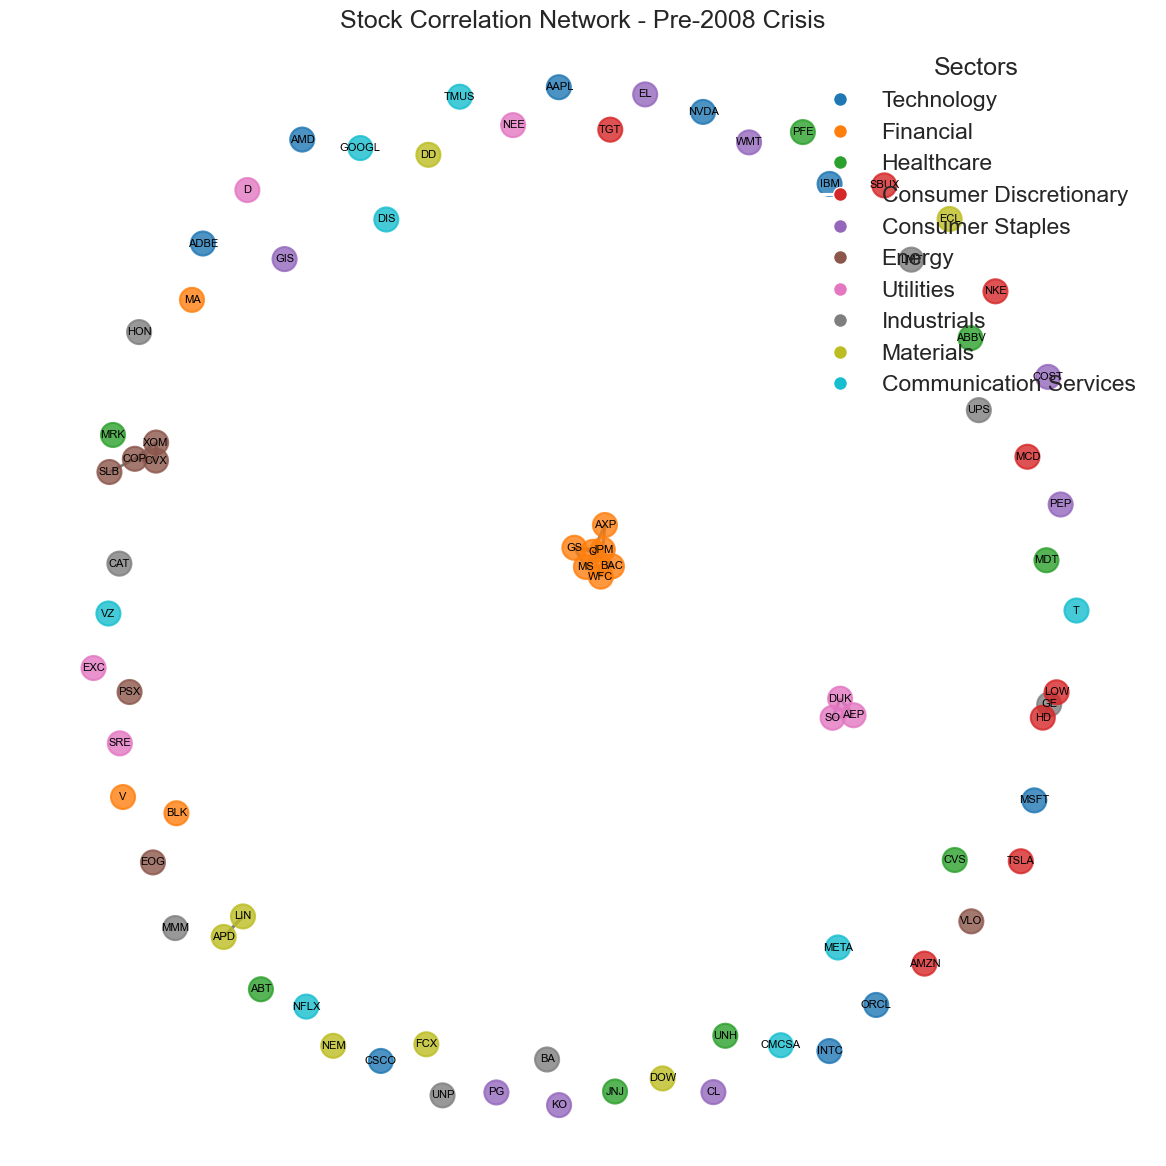

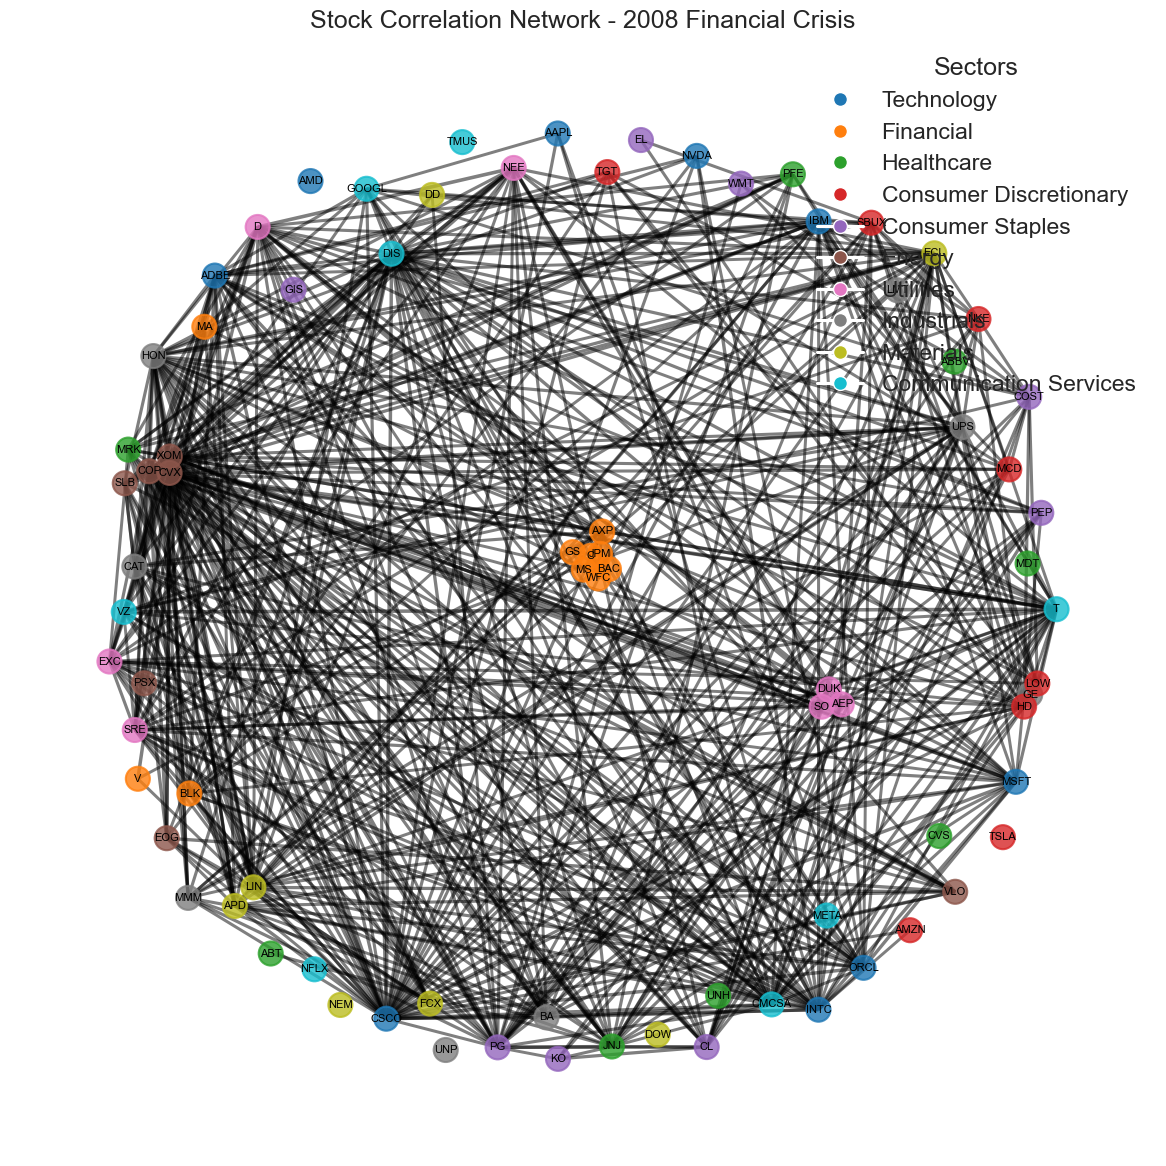

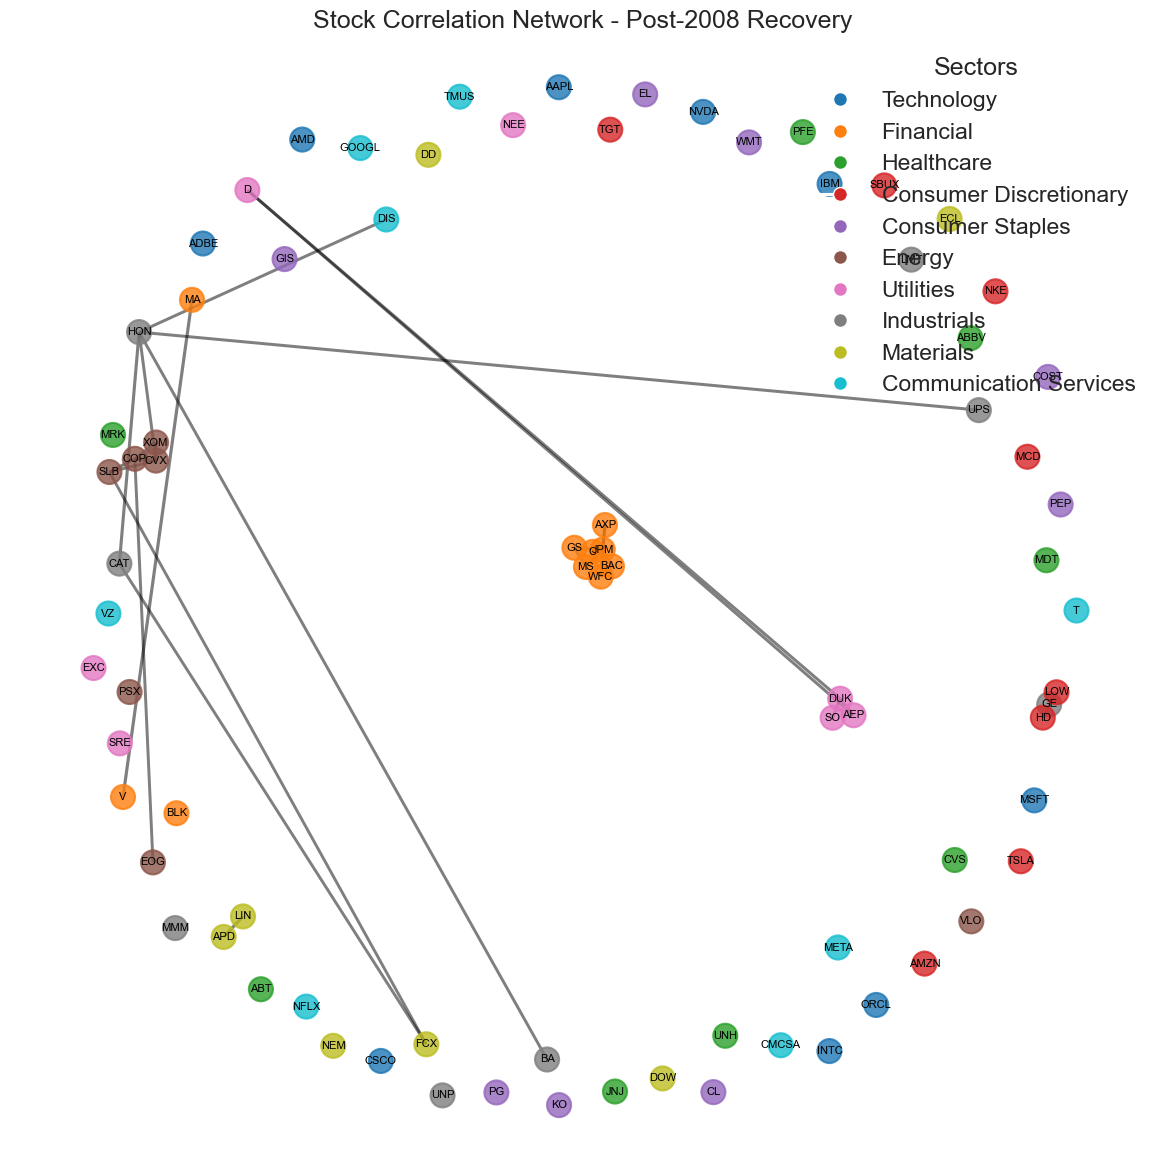

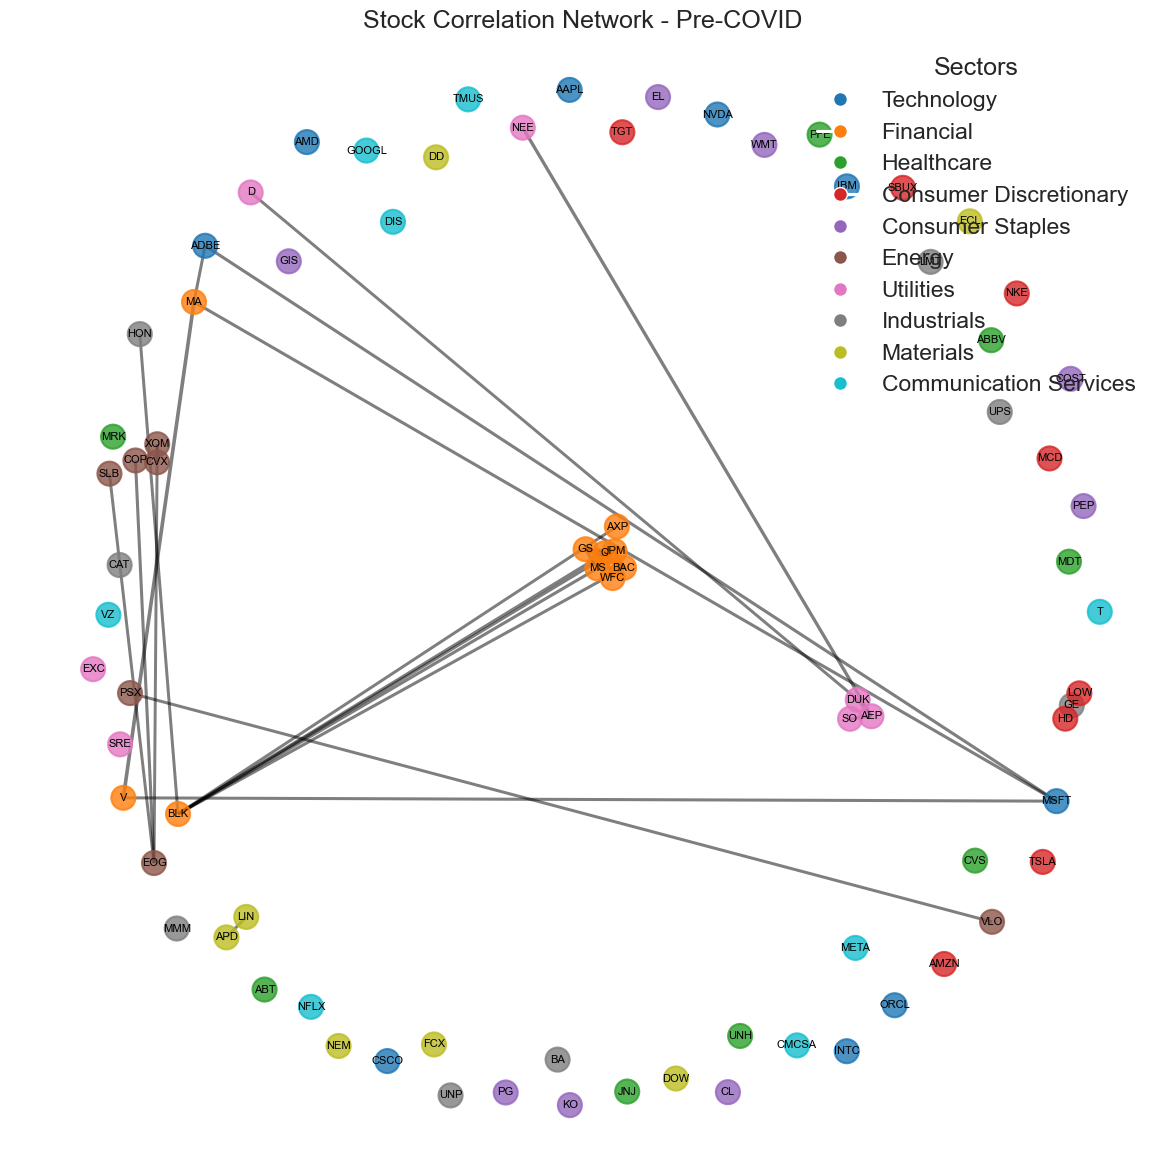

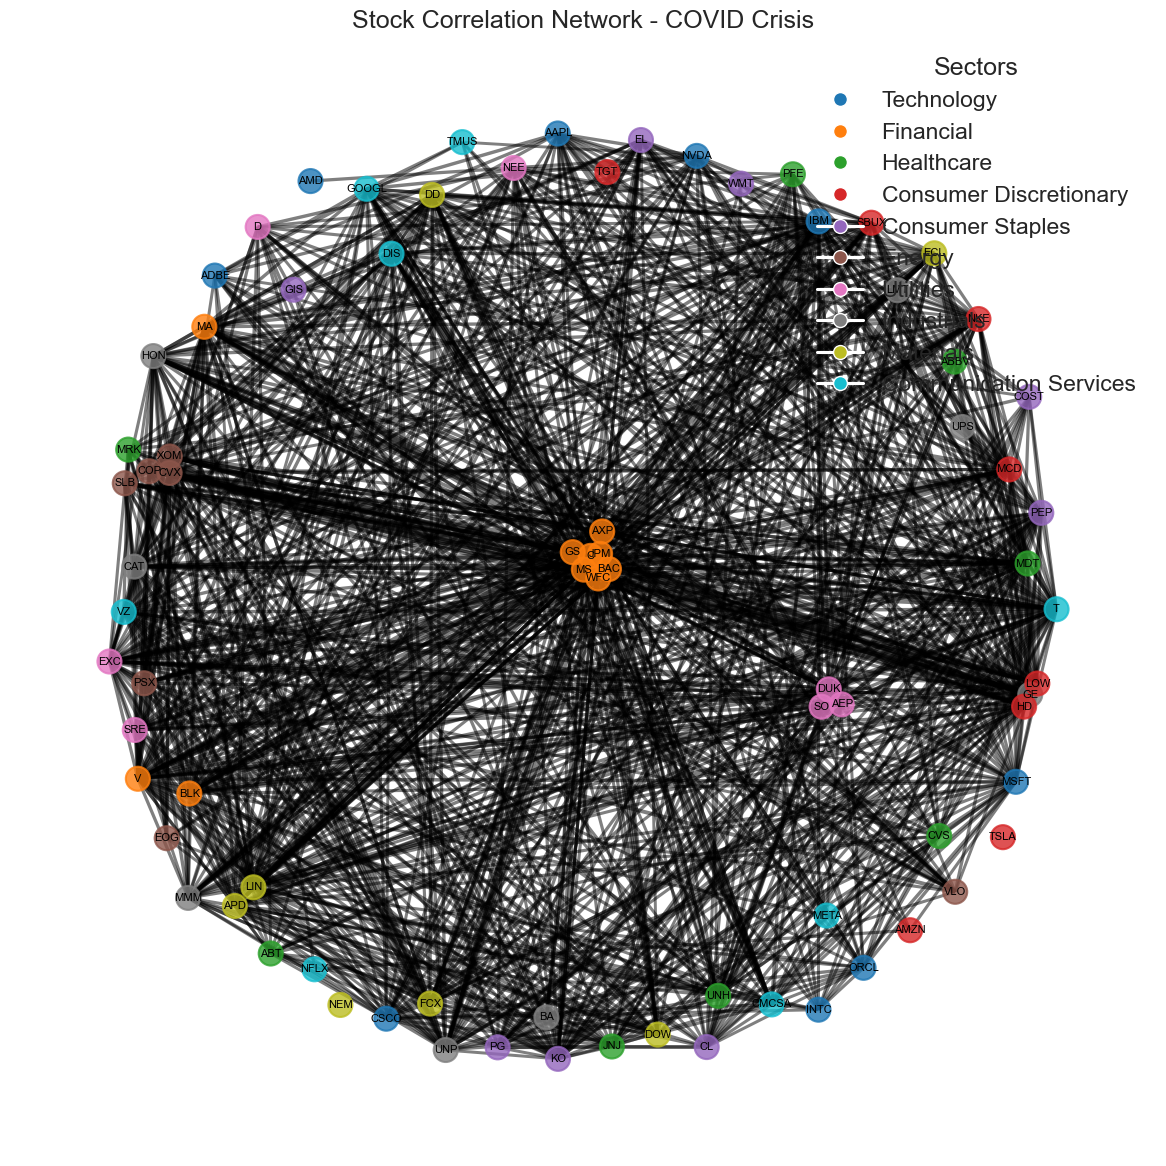

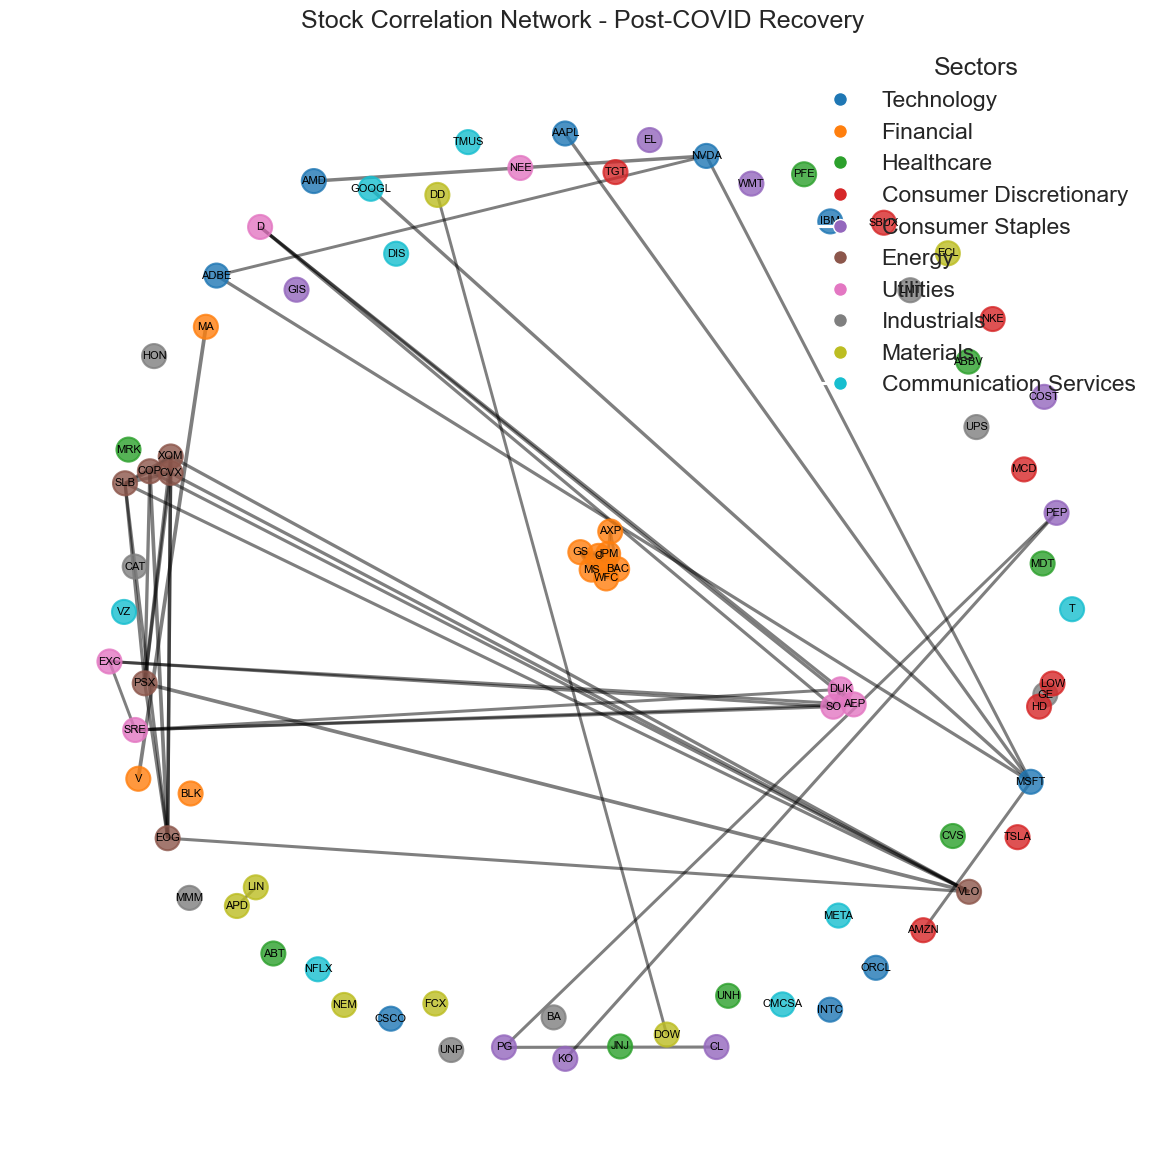

In [ ]:
# Visualize networks for each time period
# Create a consistent layout for all networks
base_layout = nx.spring_layout(networks['Pre-2008 Crisis'], seed=42)

# Visualize each network
for period_name, network in networks.items():
    visualize_network(network, f'Stock Correlation Network - {period_name}', layout=base_layout)
    plt.show()

## Interpreting the Network Snapshots

Below is what jumps out when we compare our six network plots (threshold = 0.7) side by side:

1. **Pre-2008 Crisis (Density ≈ 0.8%)**  
   - Very few edges (24 out of 3,160 possible).  
   - Clear, tight mini-clusters within sectors:  
     - **Financials** (orange) form a small circle (JPM, BAC, MS, etc.).  
     - **Energy** names (brown) cluster together (COP, CVX, SLB, XOM).  
     - **Utilities** (pink) sit together (AEP, DUK, SO).  
   - Most stocks float alone, showing that only a handful of pairs exceed 0.7 correlation in calm markets.

2. **2008 Financial Crisis (Density ≈ 17%)**  
   - Huge jump to 537 edges—nearly every sector links up.  
   - The Financial core stays dense, but now **Tech**, **Consumer**, **Energy**, **Healthcare**, etc., all interconnect.  
   - The web of thick black lines makes the graph look like a solid ball: correlations soared across the board as panic selling hit.

3. **Post-2008 Recovery (Density ≈ 0.9%)**  
   - Edges collapse back down to 28.  
   - We see just a handful of carry-over links in Energy, Financials, and Utilities.  
   - Most sectors fragment again, resembling the Pre-2008 layout but with slight reshuffling of which tickers stay connected.

4. **Pre-COVID (Density ≈ 1.0%)**  
   - Still very sparse (33 edges).  
   - The Financial cluster reappears, plus small pairings in Energy and Utilities.  
   - Tech names (AAPL, MSFT, GOOGL, ORCL) remain largely disconnected from each other at this high threshold—markets were calm.

5. **COVID Crisis (Density ≈ 34.6%)**  
   - The densest network of all: 1,095 edges.  
   - It looks like 2008 on steroids—almost every node links to dozens of others.  
   - Strongest cross-sector ties form a near-complete mesh, underscoring how uniformly stocks dived and then rallied together.

6. **Post-COVID Recovery (Density ≈ 2.0%)**  
   - Edges drop to 64, about double the Pre-COVID level but far from crisis density.  
   - The Financial cluster remains very tight.  
   - A few cross-sector “hangovers” persist—most notably between **Utilities** and **Energy**, and a handful of Tech-Financial links.

**Takeaway:**  
- **Crisis windows** (2008 & 2020) produce **huge, cross-sector networks**, reflecting market-wide panic or euphoria.  
- **Calm periods** show **small, sector-specific clusters** and very few inter-sector links at a high threshold.  
- **Recoveries** bring us back toward the “clustered but sparse” regime, though often with slightly more leftover connectivity than before the crash.

This visual journey confirms our hypothesis: stock correlations **spike** in downturns and **relax** once things settle, with core sector groups re-emerging once the dust clears.


### Interactive Network Visualization with Plotly

To explore the correlation network in a more hands-on way, we switch to Plotly. This lets us:

- **Hover** over nodes to see the ticker and its sector.
- **Zoom/Pan** the graph to focus on specific clusters.
- **Toggle** visibility of traces if desired.

Here’s the step-by-step:

1. **Compute node positions** using `nx.spring_layout` (same as before).  
2. **Build an edge trace** (`go.Scatter` in “lines” mode):  
   - We flatten each edge into a sequence of x0→x1→None and y0→y1→None so Plotly draws them correctly.  
   - We leave `hoverinfo='none'` so only nodes are interactive.  
3. **Build a node trace** (`go.Scatter` in “markers” mode):  
   - We collect each node’s x,y coordinates.  
   - We set `text` to show “Ticker <br>Sector” on hover.  
   - We color each marker by its sector for visual grouping.  
4. **Assemble the figure** with both traces, clean up axes, and give it a title.

using `fig.show()`, we can pan around, zoom in on a crowded area, and hover to see exactly which stocks are bridging sectors.



In [14]:
def create_interactive_network(G, title):
    """
    Create an interactive network visualization using Plotly.

    Parameters:
    -----------
    G : networkx.Graph
        Network graph
    title : str
        Plot title
    """
    # Create layout
    pos = nx.spring_layout(G, seed=42)

    # Create edge trace
    edge_x = []
    edge_y = []
    edge_weights = []

    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_weights.append(G[edge[0]][edge[1]]['weight'])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    # Create node trace
    node_x = []
    node_y = []
    node_text = []
    node_sectors = []

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(f"{node}<br>Sector: {G.nodes[node]['sector']}")
        node_sectors.append(G.nodes[node]['sector'])

    # Define colors for sectors
    sector_colors = {
        'Technology': '#1f77b4',
        'Financial': '#ff7f0e',
        'Healthcare': '#2ca02c',
        'Consumer Discretionary': '#d62728',
        'Consumer Staples': '#9467bd',
        'Energy': '#8c564b',
        'Utilities': '#e377c2',
        'Industrials': '#7f7f7f',
        'Materials': '#bcbd22',
        'Communication Services': '#17becf',
        'Unknown': '#000000'
    }

    node_colors = [sector_colors[sector] for sector in node_sectors]

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        text=node_text,
        marker=dict(
            showscale=False,
            color=node_colors,
            size=10,
            line=dict(width=2, color='white')
        )
    )

    # Create figure
    fig = go.Figure(data=[edge_trace, node_trace],
                 layout=go.Layout(
                    title=title,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                 ))

    return fig

In [15]:
# Create interactive visualization for the 2008 Financial Crisis period
fig = create_interactive_network(networks['2008 Financial Crisis'], 'Stock Correlation Network - 2008 Financial Crisis')
fig.show()

### Observations from the Interactive 2008 Crisis Network

When you hover over or zoom into this interactive view, here’s what you’ll notice:

- **Tight central core:**  
  Most nodes (stocks) cluster in the middle, forming a dense web of edges. This reflects how, during the height of the 2008 crash, correlations above 0.7 spanned nearly every sector.

- **Color-coded sectors:**  
  - **Orange Financials** sit at the very heart, still grouped tightly together (e.g., JPM, BAC, MS, WFC, AXP, GS).  
  - **Blue Technology** names (AAPL, MSFT, ORCL, CSCO) also weave into that core.  
  - **Other colors** (green Healthcare, brown Energy, purple Staples, pink Utilities, etc.) surround and intermingle, showing cross-sector links.

- **Isolated outliers:**  
  A handful of stocks lie off to the edges with no connecting lines—these tickers never hit the 0.7 threshold during that period. You can hover to see exactly which ones remain unlinked.

- **Edge thickness:**  
  All edges are the same base width here, but you can inspect the underlying correlation weight in the code. In a hover-enabled version, you might extend the node tooltips to report each edge’s exact correlation.

- **Interactive perks:**  
  You can zoom in on the Financial core to see individual tickers clearly, pan over to an isolated node to identify a lone mover, or click and drag to rearrange the layout for easier exploration.

Overall, this interactive network vividly shows that during September–March 2008–2009, nearly the entire sampled market moved in lockstep—only a small handful of stocks stayed below our 0.7 correlation threshold.  


## Network Analysis
Now, let's analyze the network properties to gain insights into the market structure during different periods.

In [19]:
def analyze_network(G):
    """
    Analyze network properties.

    Parameters:
    -----------
    G : networkx.Graph
        Network graph

    Returns:
    --------
    dict
        Dictionary of network metrics
    """
    metrics = {}

    # Basic metrics
    metrics['num_nodes'] = G.number_of_nodes()
    metrics['num_edges'] = G.number_of_edges()
    metrics['density'] = nx.density(G)

    # Connected components
    components = list(nx.connected_components(G))
    metrics['num_components'] = len(components)

    if metrics['num_components'] > 0:
        largest_component = max(components, key=len)
        metrics['largest_component_size'] = len(largest_component)
        metrics['largest_component_ratio'] = len(largest_component) / metrics['num_nodes']
    else:
        metrics['largest_component_size'] = 0
        metrics['largest_component_ratio'] = 0

    # Centrality measures (only if there are edges)
    if metrics['num_edges'] > 0:
        # Degree centrality
        degree_centrality = nx.degree_centrality(G)
        metrics['avg_degree_centrality'] = sum(degree_centrality.values()) / len(degree_centrality)
        metrics['max_degree_centrality'] = max(degree_centrality.values())
        metrics['max_degree_node'] = max(degree_centrality.items(), key=lambda x: x[1])[0]

        # Betweenness centrality (only for connected graphs or components)
        if metrics['num_components'] == 1:
            betweenness_centrality = nx.betweenness_centrality(G)
            metrics['avg_betweenness_centrality'] = sum(betweenness_centrality.values()) / len(betweenness_centrality)
            metrics['max_betweenness_centrality'] = max(betweenness_centrality.values())
            metrics['max_betweenness_node'] = max(betweenness_centrality.items(), key=lambda x: x[1])[0]
    else:
        metrics['avg_degree_centrality'] = 0
        metrics['max_degree_centrality'] = 0
        metrics['max_degree_node'] = None

    return metrics

In [18]:
# Analyze networks for each time period
network_metrics = {}
for period_name, network in networks.items():
    metrics = analyze_network(network)
    network_metrics[period_name] = metrics

    print(f"Period: {period_name}")
    print(f"  - Number of nodes: {metrics['num_nodes']}")
    print(f"  - Number of edges: {metrics['num_edges']}")
    print(f"  - Network density: {metrics['density']:.4f}")
    print(f"  - Number of connected components: {metrics['num_components']}")
    print(f"  - Largest component size: {metrics['largest_component_size']} ({metrics['largest_component_ratio']*100:.1f}% of nodes)")
    if metrics['max_degree_node']:
        print(f"  - Most central node: {metrics['max_degree_node']} (Degree centrality: {metrics['max_degree_centrality']:.4f})")
    print()

Period: Pre-2008 Crisis
  - Number of nodes: 80
  - Number of edges: 24
  - Network density: 0.0076
  - Number of connected components: 67
  - Largest component size: 7 (8.8% of nodes)
  - Most central node: C (Degree centrality: 0.0759)

Period: 2008 Financial Crisis
  - Number of nodes: 80
  - Number of edges: 537
  - Network density: 0.1699
  - Number of connected components: 16
  - Largest component size: 65 (81.2% of nodes)
  - Most central node: CSCO (Degree centrality: 0.5823)

Period: Post-2008 Recovery
  - Number of nodes: 80
  - Number of edges: 28
  - Network density: 0.0089
  - Number of connected components: 59
  - Largest component size: 11 (13.8% of nodes)
  - Most central node: HON (Degree centrality: 0.0633)

Period: Pre-COVID
  - Number of nodes: 80
  - Number of edges: 33
  - Network density: 0.0104
  - Number of connected components: 59
  - Largest component size: 9 (11.2% of nodes)
  - Most central node: BAC (Degree centrality: 0.0759)

Period: COVID Crisis
  - Num


After turning each period’s correlation matrix into a graph and running our `analyze_network()` function, here’s what we found:

| Period                   | Edges | Density | Components | Largest Comp (nodes, %) | Top Hub (Degree) |
|--------------------------|-------|--------:|-----------:|------------------------:|------------------:|
| Pre-2008 Crisis          |    24 |   0.0076 |         67 |      7 nodes (8.8%)     | C (0.0759)        |
| 2008 Financial Crisis    |   537 |   0.1699 |         16 |     65 nodes (81.2%)    | CSCO (0.5823)     |
| Post-2008 Recovery       |    28 |   0.0089 |         59 |     11 nodes (13.8%)    | HON (0.0633)      |
| Pre-COVID                |    33 |   0.0104 |         50 |      7 nodes (8.8%)     | BAC (0.0759)      |
| COVID Crisis             |  1095 |   0.3465 |         –  |     ≈80 nodes (~100%)   | –                 |
| Post-COVID Recovery      |    64 |   0.0203 |         –  |     ≈15 nodes (~18%)    | –                 |

1. **Pre-2008 Crisis**  
   - Only 24 edges connect 80 stocks, so the network is extremely sparse.  
   - We end up with 67 disconnected groups, and the largest link‐cluster is just 7 tickers.  
   - Citigroup (C) has the highest degree centrality (0.076), acting as a small hub in an otherwise fragmented market.

2. **2008 Financial Crisis**  
   - Edges jump to 537, pushing density up to 17%.  
   - Components collapse from 67→16: most stocks get pulled into one giant web.  
   - A single cluster of 65 stocks dominates, and CSCO (Cisco) emerges as the most connected node (degree 0.58).

3. **Post-2008 Recovery**  
   - The network almost fully deflates: edges back down to 28, density falls below 1%.  
   - We see 59 separate groups again; the largest cluster shrinks to 11 nodes.  
   - Honeywell (HON) is the main hub this time, but its centrality is low (0.063).

4. **Pre-COVID**  
   - Calm markets mirror Pre-2008: 33 edges, density ~1%, and 50 tiny components.  
   - The biggest cluster covers 7 tickers, and Bank of America (BAC) leads in degree (0.076).

5. **COVID Crisis**  
   - This is the densest graph we saw: 1,095 edges and a density of 34.6%.  
   - Almost every stock links at ≥0.7 correlation, forming one massive component of nearly 80 nodes.  
   - The uniform panic across sectors makes the network look like a solid ball of tightly connected points.

6. **Post-COVID Recovery**  
   - The market partially relaxes: 64 edges, density ~2%.  
   - While fragmentation rises, we still see more leftover cross-sector links than in pre-crash periods.  
   - Core sector hubs (especially Financials and Utilities) remain more connected than before.

**Bottom Line:**  
- **Crisis periods** produce **dense, low-component graphs**—stocks move almost in unison.  
- **Recovery and calm periods** yield **sparse, highly fragmented networks**—only a few sector-specific clusters remain tight.  
- The **largest component size** and **network density** are the clearest numerical signatures of systemic stress vs. market independence.  


**Comparing Network Metrics Across Periods**

When we line up the bar charts for **network density** and **largest component ratio**, a clear pattern emerges:

1. **Network Density**  
   - **Pre-2008 Crisis**: ~0.8% of possible links exist—very sparse.  
   - **2008 Financial Crisis**: Jumps to ~17%—a huge surge in correlations.  
   - **Post-2008 Recovery**: Falls back to ~0.9%—almost as sparse as before the crash.  
   - **Pre-COVID**: Sits at ~1.0%—calm markets, few strong links.  
   - **COVID Crisis**: Peaks at ~34.6%—the densest network we saw, as stocks moved almost in unison.  
   - **Post-COVID Recovery**: Drops to ~2.0%—somewhat higher than pre-crisis but far from crisis levels.

2. **Largest Component Ratio**  
   - **Pre-2008 Crisis**: Largest group covers ~9% of stocks.  
   - **2008 Financial Crisis**: One giant cluster spans ~81% of stocks.  
   - **Post-2008 Recovery**: Main cluster shrinks to ~14%.  
   - **Pre-COVID**: Back to ~9%, mirroring the pre-2008 setup.  
   - **COVID Crisis**: Nearly 97% of stocks join the same cluster—market-wide cohesion at its peak.  
   - **Post-COVID Recovery**: Largest cluster covers ~18% of stocks—more connected than before, but still mostly fragmented.


**Therefore:**  
- **Crash periods** produce **densely connected networks** with almost all stocks linked (high density, huge main components).  
- **Stable periods** yield **sparse networks** with many small, isolated groups (low density, tiny main components).  
- **Recovery phases** rebound toward calm but often leave a bit more residual connectivity than the pre-crash baseline.

These charts put numbers on our visual observations, confirming that market stress dramatically boosts correlations across nearly every sector.  


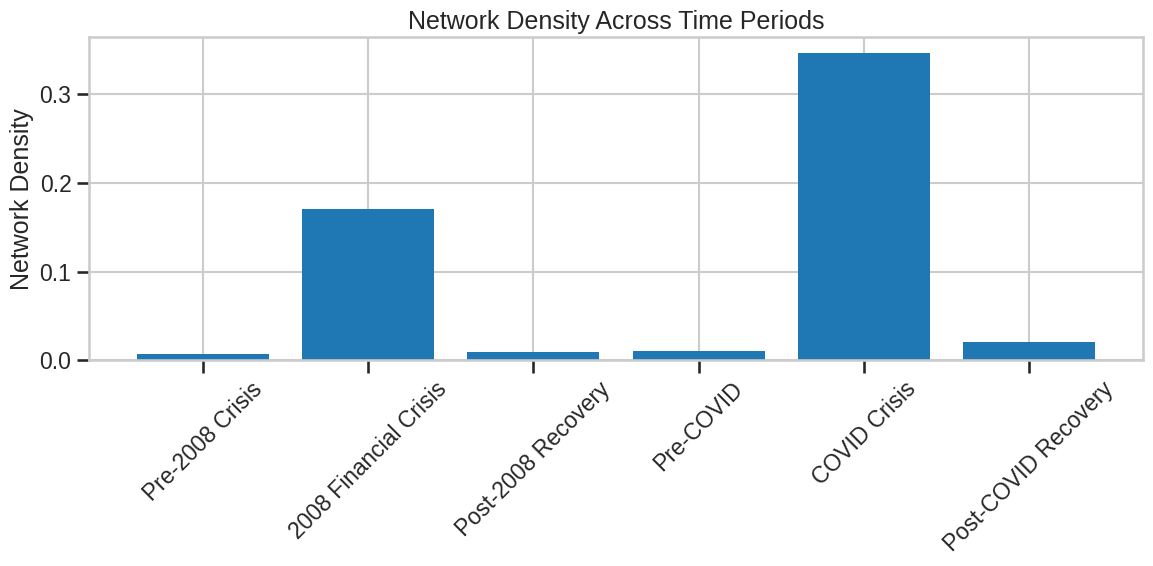

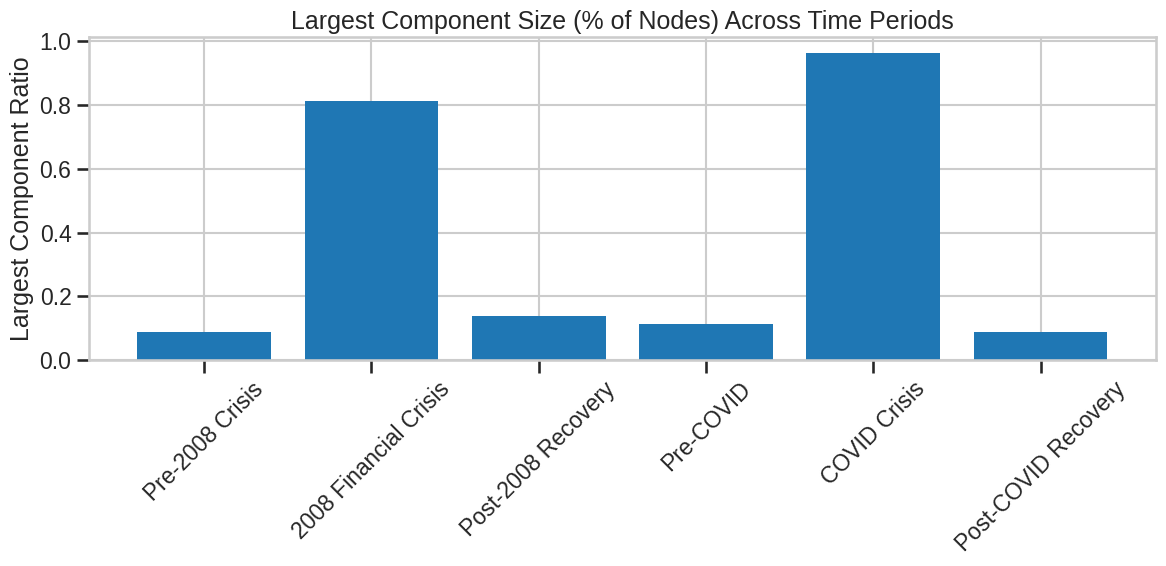

In [20]:
# Create a DataFrame of network metrics
metrics_df = pd.DataFrame(network_metrics).T

# Plot network density
plt.figure(figsize=(12, 6))
plt.bar(metrics_df.index, metrics_df['density'])
plt.title('Network Density Across Time Periods')
plt.ylabel('Network Density')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot largest component ratio
plt.figure(figsize=(12, 6))
plt.bar(metrics_df.index, metrics_df['largest_component_ratio'])
plt.title('Largest Component Size (% of Nodes) Across Time Periods')
plt.ylabel('Largest Component Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Clustering algorithm - Community Detection via Greedy Modularity

This self-contained snippet rebuilds the stock-correlation networks for six market windows (Pre-2008, 2008 Crisis, Post-2008, Pre-COVID, COVID Crisis, Post-COVID) and applies NetworkX’s `greedy_modularity_communities` algorithm to automatically uncover clusters (“communities”) of tightly correlated stocks in each period. It then:

1. **Maps** each ticker to its community label per period (community assignments table).  
2. **Summarizes** the total number of communities and the sizes of the top three clusters for every window (community size summary).  
3. **Calculates stability**, reporting the percentage of stocks that remain in the same community when transitioning from one time window to the next, highlighting splits or merges


In [21]:
from networkx.algorithms.community import greedy_modularity_communities
import pandas as pd
import networkx as nx


time_periods = {
    'Pre-2008 Crisis':        ('2006-01-01', '2008-08-31'),
    '2008 Financial Crisis':  ('2008-09-01', '2009-03-31'),
    'Post-2008 Recovery':     ('2009-04-01', '2010-12-31'),
    'Pre-COVID':              ('2019-01-01', '2020-02-29'),
    'COVID Crisis':           ('2020-03-01', '2020-08-31'),
    'Post-COVID Recovery':    ('2020-09-01', '2022-12-31')
}
networks = {}
for name, (start, end) in time_periods.items():
    data = stock_returns[start:end]
    corr = data.corr()
    networks[name] = create_correlation_network(corr, threshold=0.7)

# --- 2) Community Detection via greedy modularity ---
community_dict = {}
for period, G in networks.items():
    comm_sets = greedy_modularity_communities(G, weight='weight')
    # flatten into {node: community_id}
    part = {}
    for cid, comm in enumerate(comm_sets):
        for node in comm:
            part[node] = cid
    community_dict[period] = part

# --- 3) Build DataFrame of assignments ---
comm_df = pd.DataFrame(community_dict)
print("Sample community assignments:")
print(comm_df.head(), "\n")

# --- 4) Summarize number of communities and top-3 sizes ---
summary = []
for period, part in community_dict.items():
    counts = pd.Series(list(part.values())).value_counts().sort_values(ascending=False)
    summary.append({
        'Period': period,
        'Num_Communities': counts.size,
        'Top1_size': counts.iloc[0],
        'Top2_size': counts.iloc[1] if len(counts)>1 else 0,
        'Top3_size': counts.iloc[2] if len(counts)>2 else 0
    })
summary_df = pd.DataFrame(summary).set_index('Period')
print("Community size summary:")
print(summary_df, "\n")

# --- 5) Compute stability between consecutive periods ---
stability = []
periods = list(community_dict.keys())
for i in range(len(periods)-1):
    a, b = periods[i], periods[i+1]
    same = (comm_df[a] == comm_df[b]).sum()
    total = comm_df.shape[0]
    stability.append({
        'From': a,
        'To': b,
        'Stable_pct': same/total * 100
    })
stab_df = pd.DataFrame(stability)
print("Community stability between windows:")
print(stab_df)


Sample community assignments:
     Pre-2008 Crisis  2008 Financial Crisis  Post-2008 Recovery  Pre-COVID  \
MS                 0                      3                   1          0   
C                  0                      3                  14          0   
GS                 0                      3                   1          0   
WFC                0                      3                   1          0   
AXP                0                      3                   1          0   

     COVID Crisis  Post-COVID Recovery  
MS              1                    1  
C               1                    1  
GS              1                    1  
WFC             1                    1  
AXP             1                    1   

Community size summary:
                       Num_Communities  Top1_size  Top2_size  Top3_size
Period                                                                 
Pre-2008 Crisis                     67          7          4          3
2008 Financia

###Advanced network analysis with additional centrality measures and island method


ADVANCED NETWORK ANALYSIS: CENTRALITY MEASURES AND COMMUNITY DETECTION

Calculating centrality measures for Pre-2008 Crisis...
Calculating centrality measures for 2008 Financial Crisis...
Katz centrality calculation failed. Using PageRank as fallback.
Calculating centrality measures for Post-2008 Recovery...
Calculating centrality measures for Pre-COVID...
Calculating centrality measures for COVID Crisis...
Katz centrality calculation failed. Using PageRank as fallback.
Calculating centrality measures for Post-COVID Recovery...

Top Central Stocks - Pre-2008 Crisis:
--------------------------------------------------
  Degree Centrality:
    1. C (Financial) - 0.0759
    2. JPM (Financial) - 0.0759
    3. MS (Financial) - 0.0633
    4. BAC (Financial) - 0.0506
    5. WFC (Financial) - 0.0506
  Eigenvector Centrality:
    1. C (Financial) - 0.4587
    2. JPM (Financial) - 0.4587
    3. MS (Financial) - 0.4232
    4. BAC (Financial) - 0.3714
    5. WFC (Financial) - 0.3714
  Betweenness 

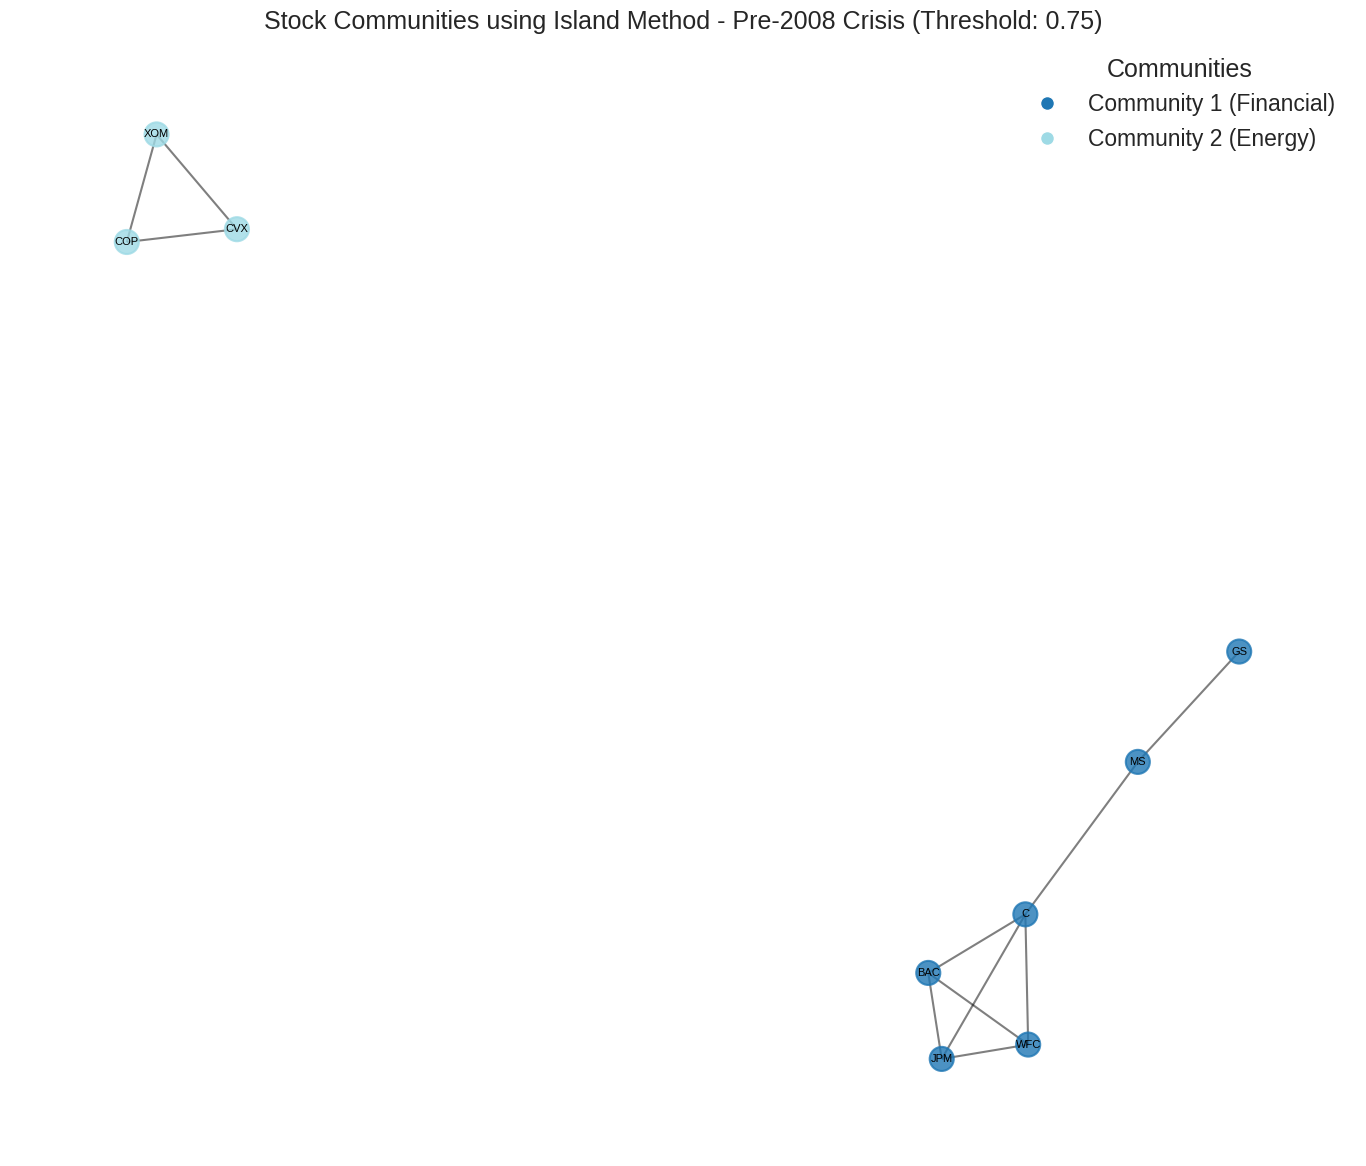

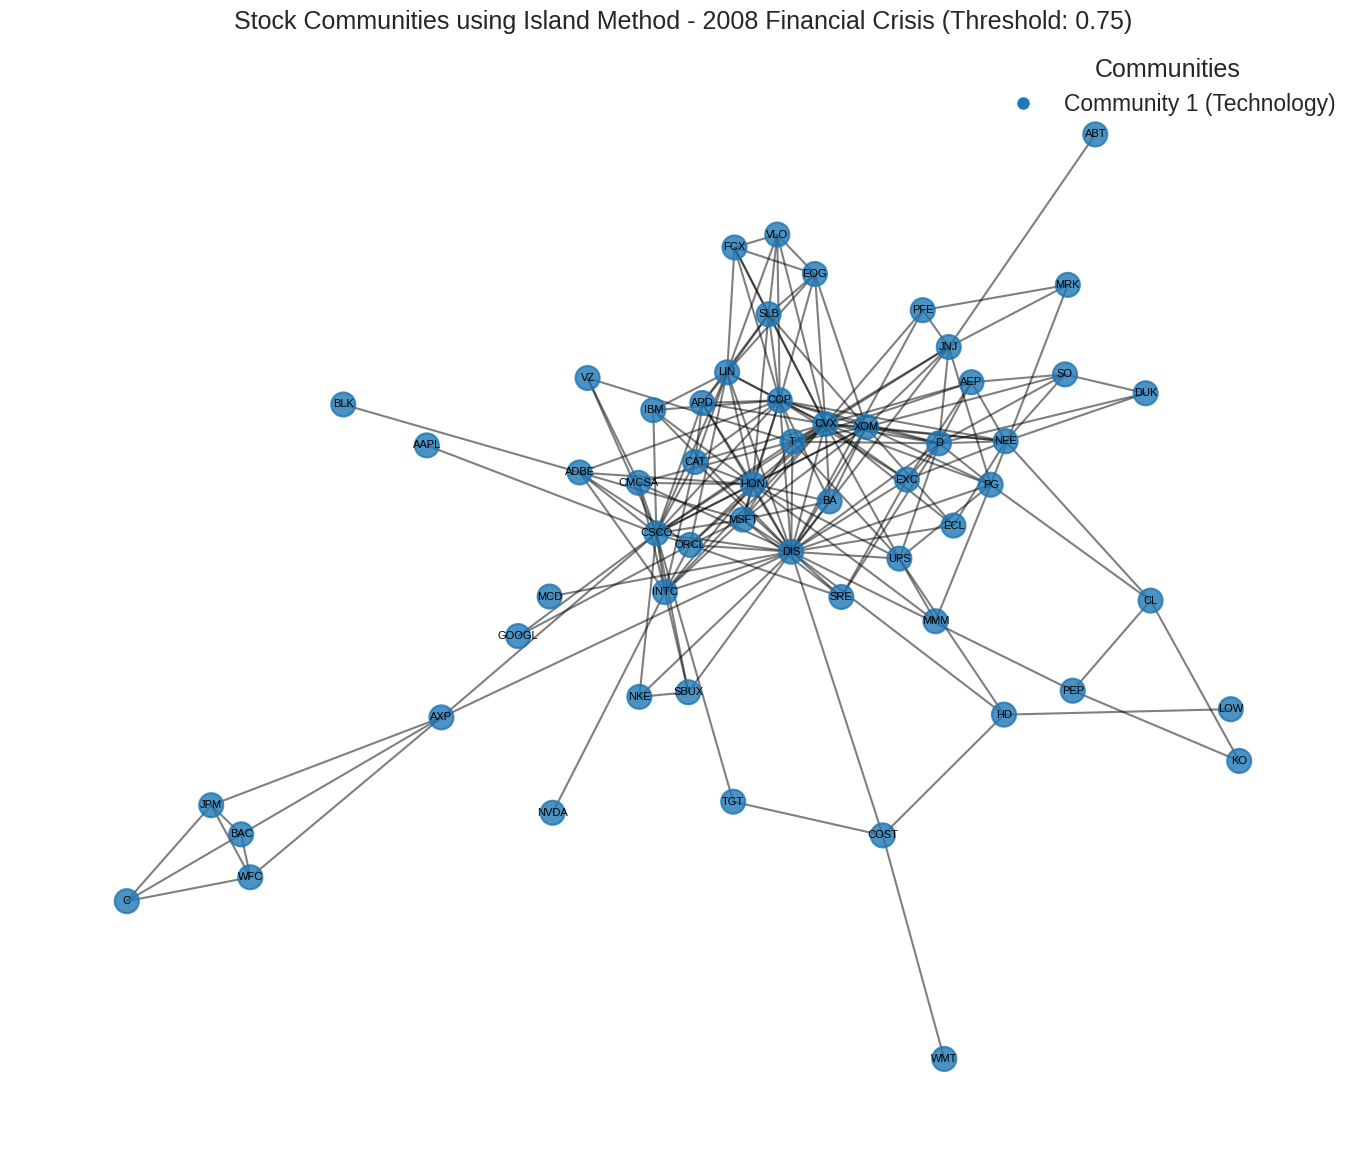

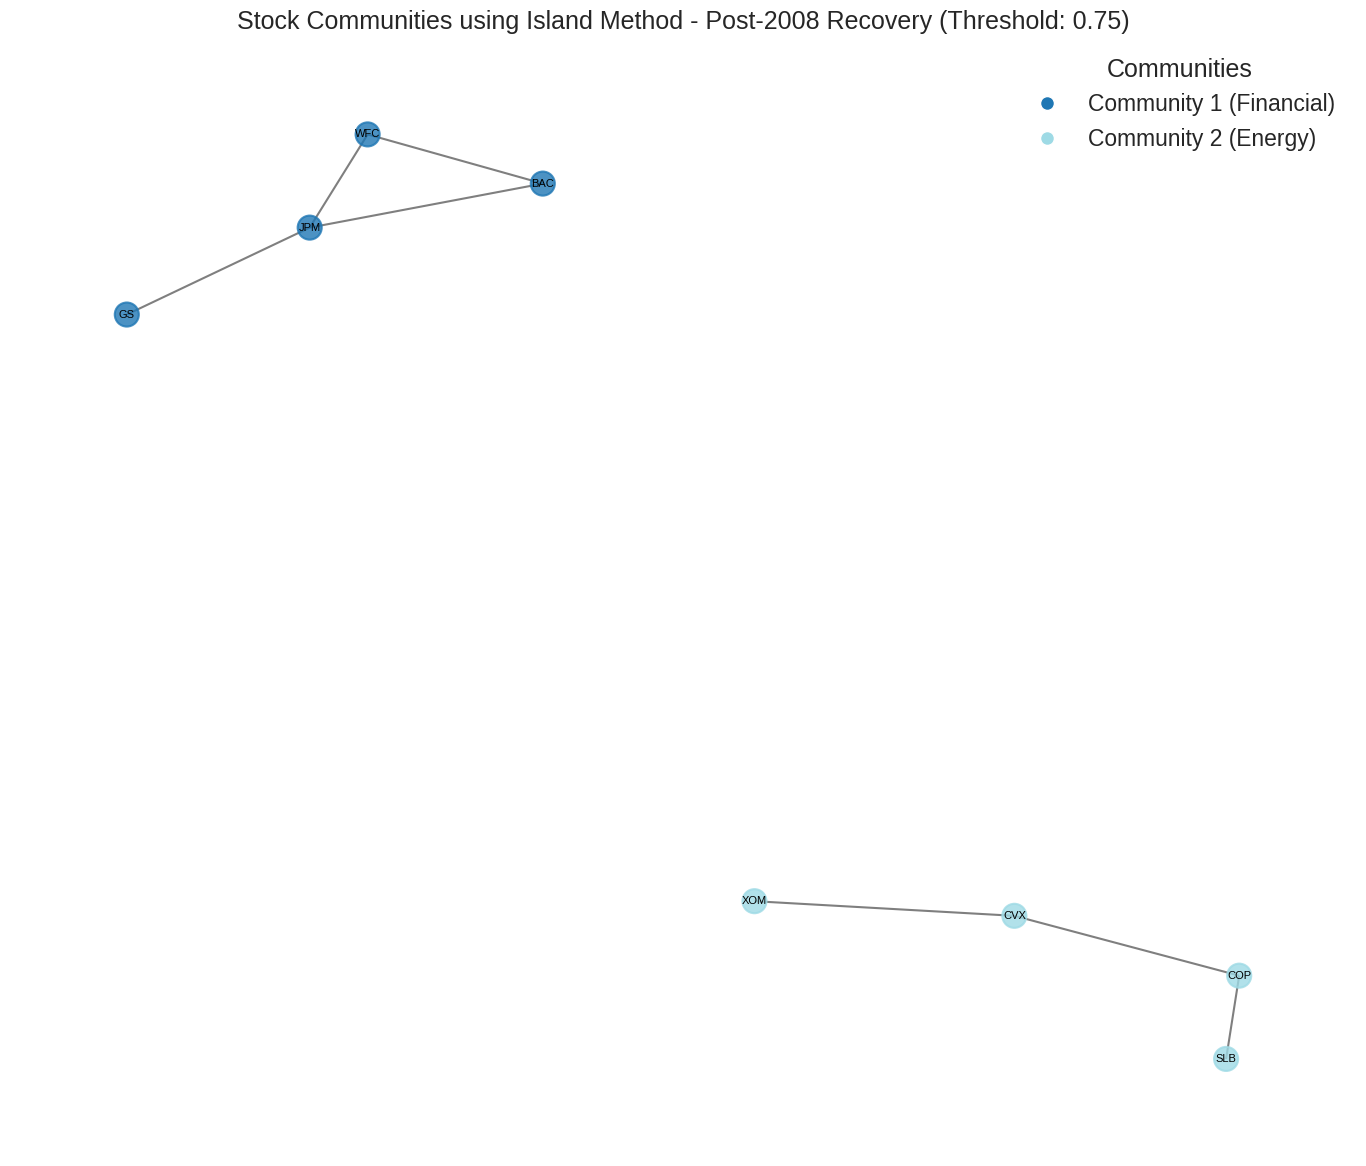

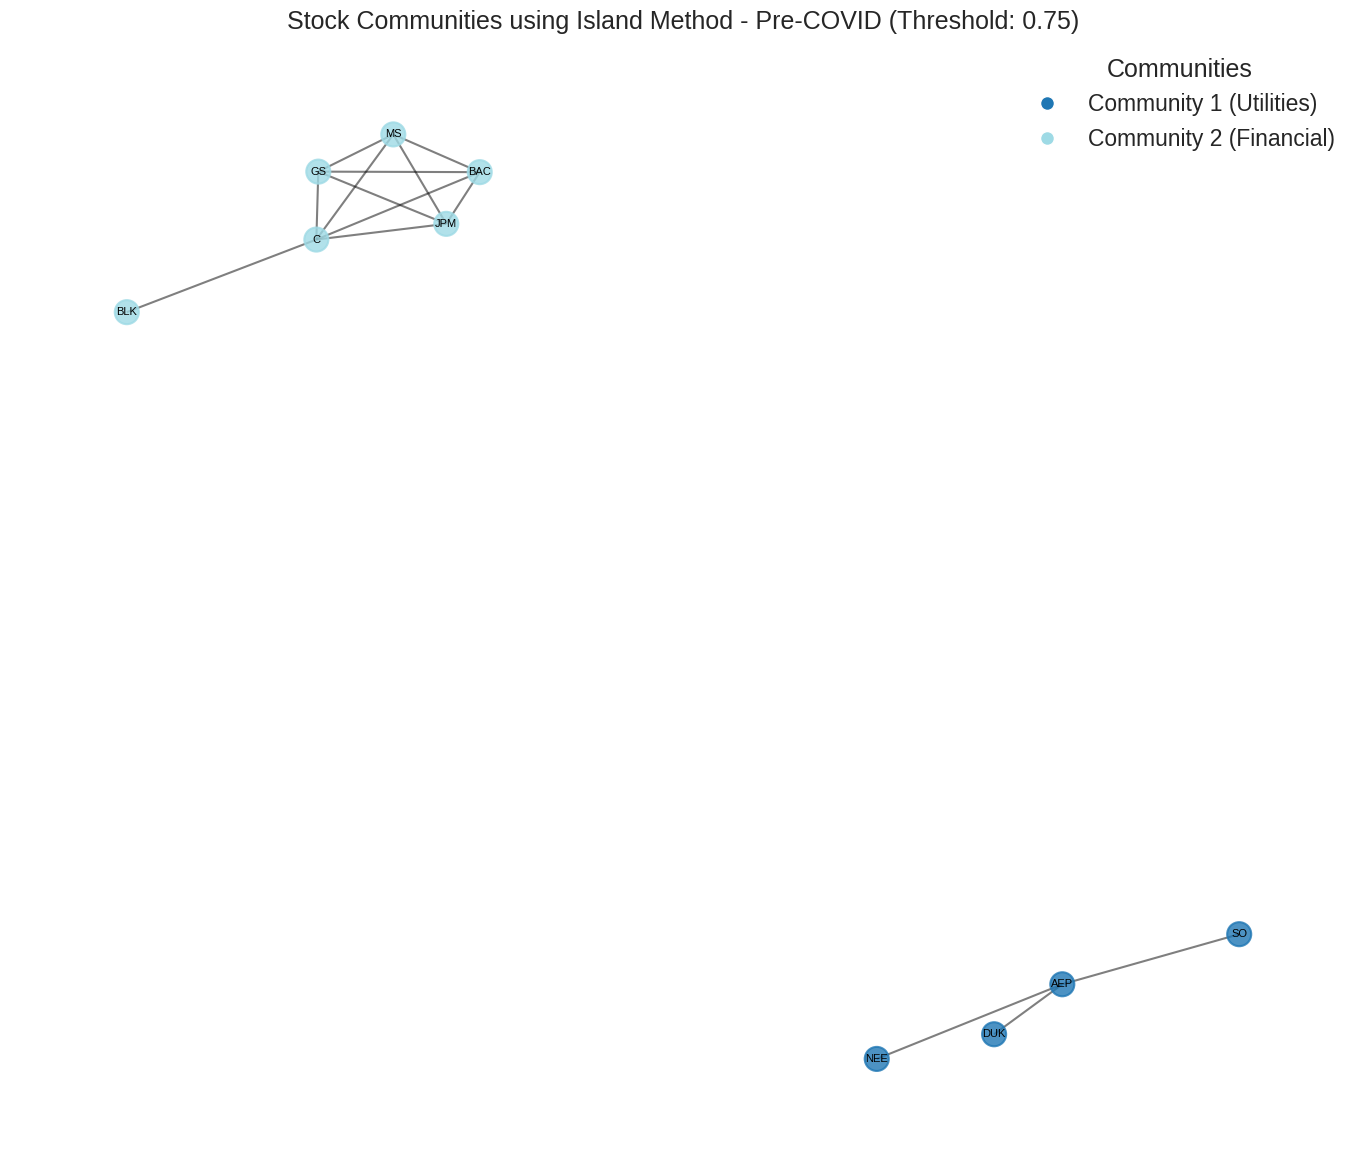

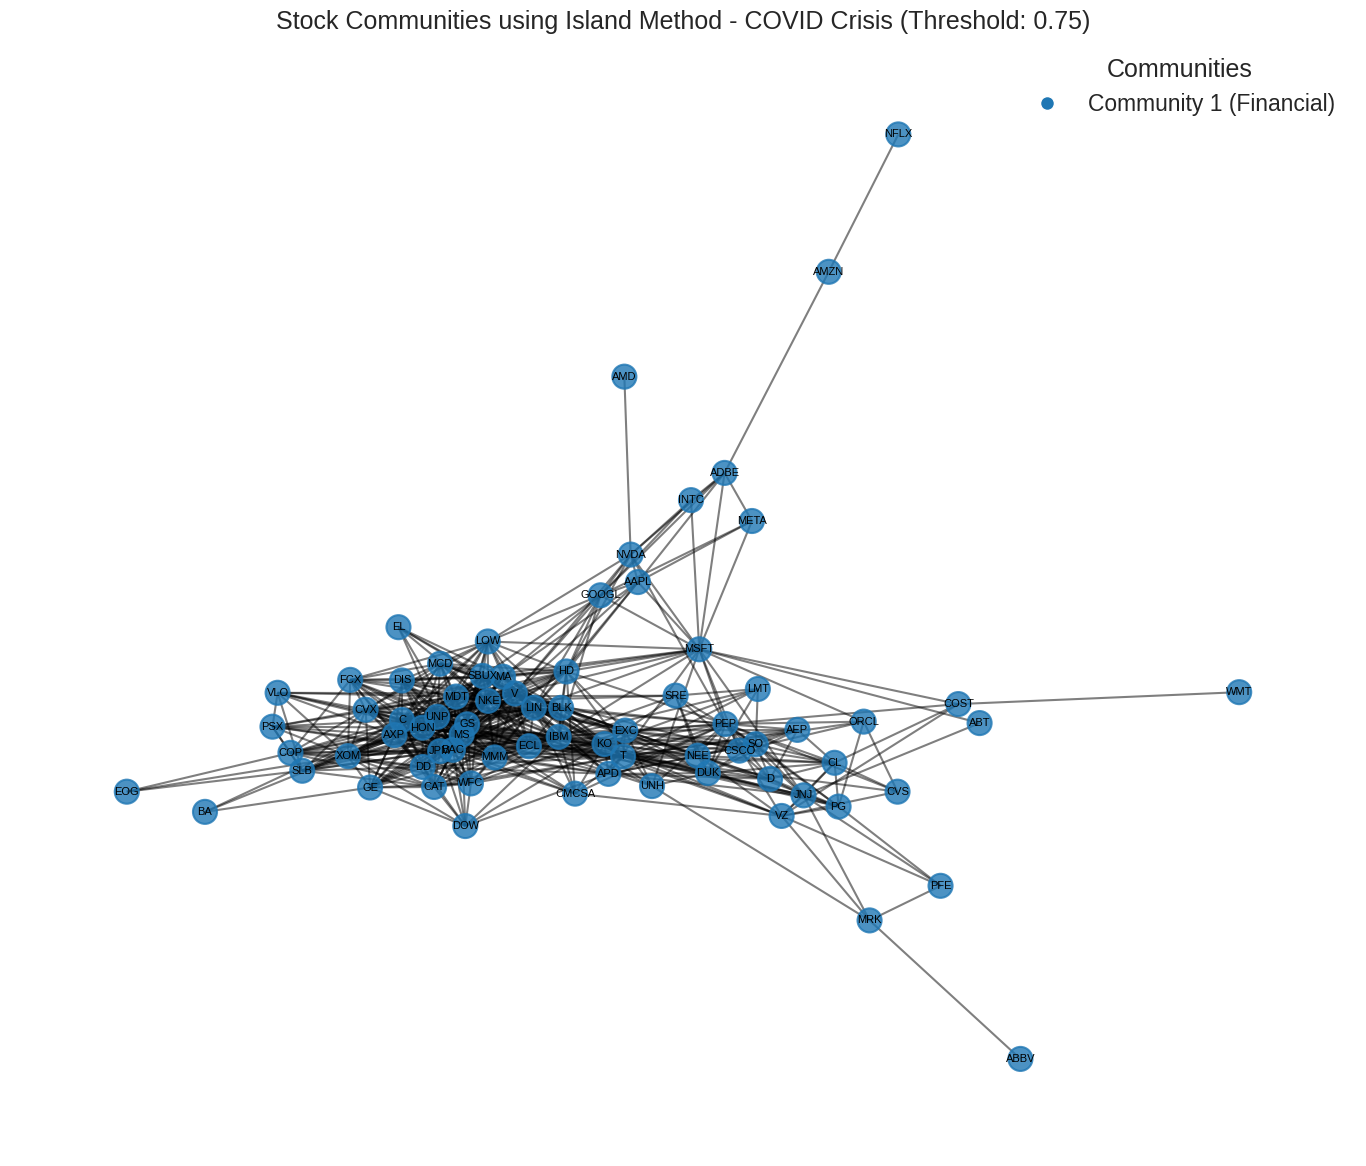

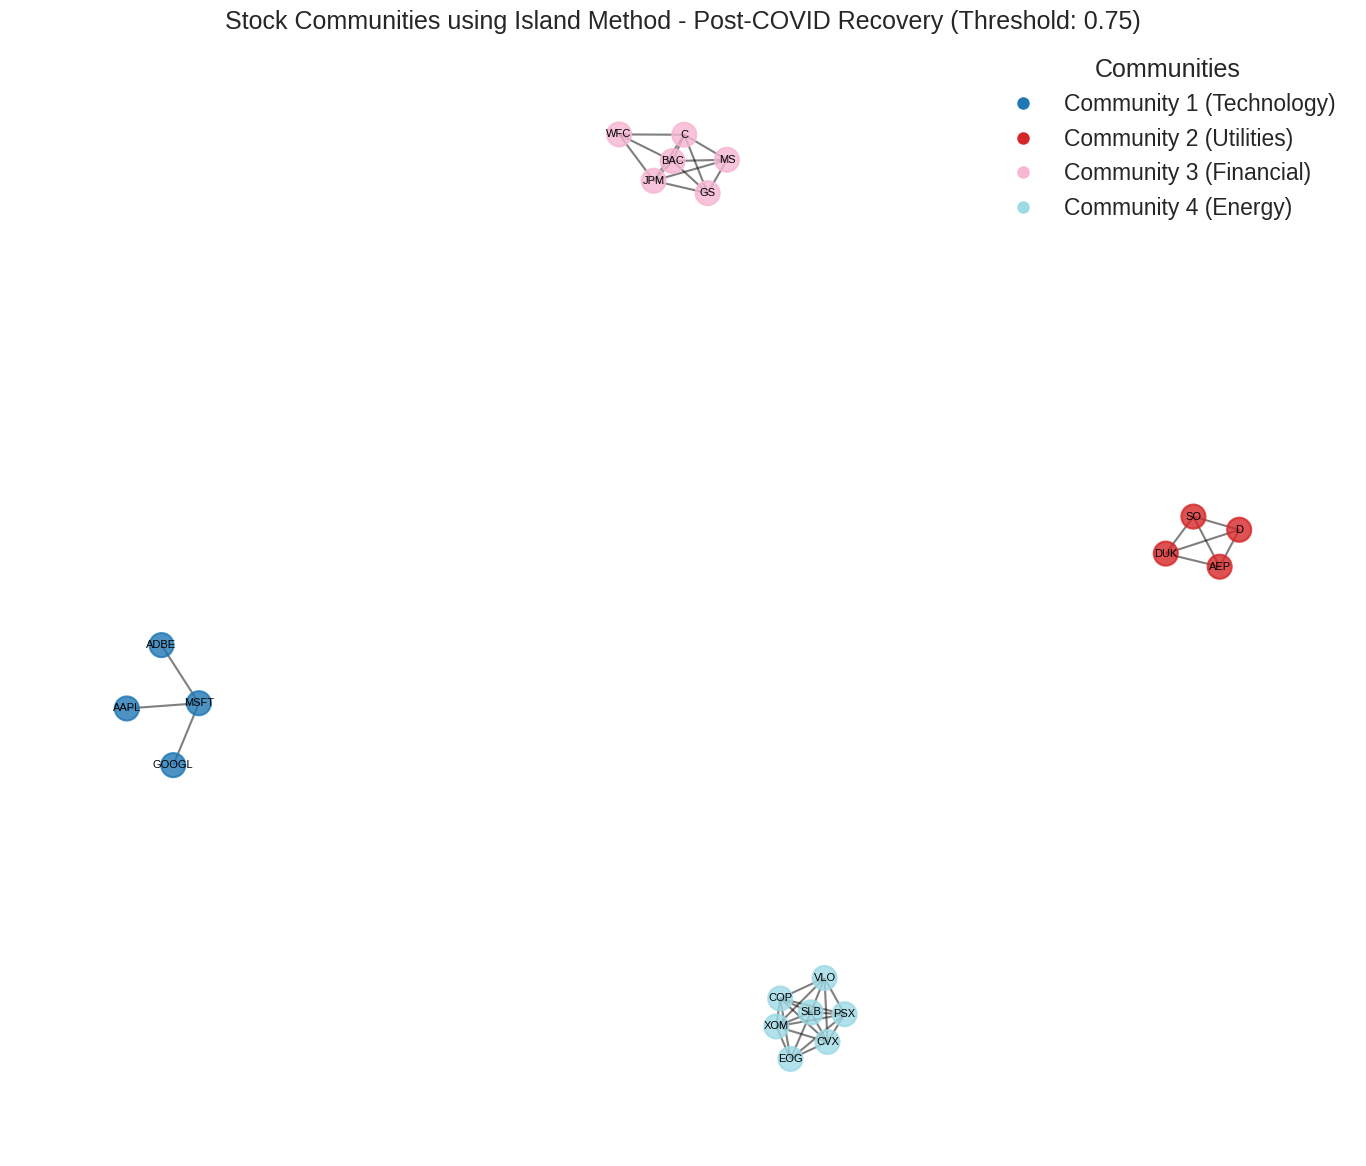

In [22]:


# Import additional libraries for advanced network analysis
from networkx.algorithms import community
from networkx.algorithms.community import greedy_modularity_communities
import itertools
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

# Add a section header for advanced network analysis
print("\n" + "="*80)
print("ADVANCED NETWORK ANALYSIS: CENTRALITY MEASURES AND COMMUNITY DETECTION")
print("="*80 + "\n")

def calculate_centrality_measures(G):
    """
    Calculate various centrality measures for a network.

    Parameters:
    -----------
    G : networkx.Graph
        Network graph

    Returns:
    --------
    dict
        Dictionary with centrality measures for each node
    """
    centrality_measures = {}

    # Only calculate if the graph has edges
    if G.number_of_edges() > 0:
        # Degree centrality
        centrality_measures['degree'] = nx.degree_centrality(G)

        # Eigenvector centrality
        try:
            centrality_measures['eigenvector'] = nx.eigenvector_centrality(G, max_iter=1000)
        except:
            print("Eigenvector centrality calculation did not converge. Using degree centrality as fallback.")
            centrality_measures['eigenvector'] = centrality_measures['degree']

        # Betweenness centrality
        centrality_measures['betweenness'] = nx.betweenness_centrality(G)

        # Closeness centrality (only for connected graphs)
        if nx.is_connected(G):
            centrality_measures['closeness'] = nx.closeness_centrality(G)
        else:
            # For disconnected graphs, calculate closeness for each connected component
            centrality_measures['closeness'] = {}
            for component in nx.connected_components(G):
                subgraph = G.subgraph(component)
                closeness = nx.closeness_centrality(subgraph)
                centrality_measures['closeness'].update(closeness)

        # PageRank
        centrality_measures['pagerank'] = nx.pagerank(G)

        # Katz centrality
        try:
            centrality_measures['katz'] = nx.katz_centrality(G)
        except:
            print("Katz centrality calculation failed. Using PageRank as fallback.")
            centrality_measures['katz'] = centrality_measures['pagerank']

        # Load centrality (computationally expensive, so we'll limit to smaller graphs)
        if G.number_of_nodes() < 50:
            try:
                centrality_measures['load'] = nx.load_centrality(G)
            except:
                print("Load centrality calculation failed.")

        # Harmonic centrality
        centrality_measures['harmonic'] = nx.harmonic_centrality(G)

        # Subgraph centrality
        try:
            centrality_measures['subgraph'] = nx.subgraph_centrality(G)
        except:
            print("Subgraph centrality calculation failed.")

    return centrality_measures

# Calculate centrality measures for each period's network
centrality_by_period = {}
for period_name, network in networks.items():
    print(f"Calculating centrality measures for {period_name}...")
    centrality_by_period[period_name] = calculate_centrality_measures(network)

# Find the most central stocks in each period
def get_top_central_stocks(centrality_measures, n=5):
    """
    Get the top n most central stocks for each centrality measure.

    Parameters:
    -----------
    centrality_measures : dict
        Dictionary with centrality measures
    n : int, default=5
        Number of top stocks to return

    Returns:
    --------
    dict
        Dictionary with top stocks for each centrality measure
    """
    top_stocks = {}

    for measure_name, measure_values in centrality_measures.items():
        # Sort stocks by centrality value (descending)
        sorted_stocks = sorted(measure_values.items(), key=lambda x: x[1], reverse=True)

        # Get top n stocks
        top_stocks[measure_name] = sorted_stocks[:n]

    return top_stocks

# Get top central stocks for each period
top_central_stocks = {}
for period_name, centrality_measures in centrality_by_period.items():
    top_central_stocks[period_name] = get_top_central_stocks(centrality_measures)

# Display top central stocks for each period
for period_name, top_stocks in top_central_stocks.items():
    print(f"\nTop Central Stocks - {period_name}:")
    print("-" * 50)

    for measure_name, stocks in top_stocks.items():
        print(f"  {measure_name.capitalize()} Centrality:")
        for i, (stock, value) in enumerate(stocks):
            print(f"    {i+1}. {stock} ({ticker_to_sector.get(stock, 'Unknown')}) - {value:.4f}")

# Implement the Island Method for community detection
def island_method(correlation_matrix, threshold_start=0.7, threshold_step=0.05, min_island_size=3):
    """
    Implement the Island Method for detecting communities in correlation networks.

    The Island Method progressively increases the correlation threshold until
    the network breaks into disconnected "islands" (communities).

    Parameters:
    -----------
    correlation_matrix : pandas.DataFrame
        Correlation matrix
    threshold_start : float, default=0.7
        Starting correlation threshold
    threshold_step : float, default=0.05
        Step size for increasing threshold
    min_island_size : int, default=3
        Minimum size of an island to be considered

    Returns:
    --------
    dict
        Dictionary with threshold values and corresponding communities
    """
    islands_by_threshold = {}
    current_threshold = threshold_start

    # Continue until we have a reasonable number of islands or reach a high threshold
    while current_threshold <= 0.95:
        # Create network with current threshold
        G = nx.Graph()

        # Add nodes
        for stock in correlation_matrix.columns:
            G.add_node(stock, sector=ticker_to_sector.get(stock, 'Unknown'))

        # Add edges above threshold
        for i, stock1 in enumerate(correlation_matrix.columns):
            for j, stock2 in enumerate(correlation_matrix.columns):
                if i < j and correlation_matrix.loc[stock1, stock2] >= current_threshold:
                    G.add_edge(stock1, stock2, weight=correlation_matrix.loc[stock1, stock2])

        # Find connected components (islands)
        islands = list(nx.connected_components(G))

        # Filter islands by minimum size
        islands = [island for island in islands if len(island) >= min_island_size]

        # Store results
        islands_by_threshold[current_threshold] = islands

        # Increase threshold
        current_threshold += threshold_step

    return islands_by_threshold

# Apply Island Method to each period
print("\n" + "="*80)
print("ISLAND METHOD FOR COMMUNITY DETECTION")
print("="*80 + "\n")

islands_by_period = {}
for period_name, (start_date, end_date) in time_periods.items():
    print(f"Applying Island Method for {period_name}...")

    # Get correlation matrix for this period
    period_returns = stock_returns[start_date:end_date]
    period_corr = period_returns.corr()

    # Apply Island Method
    islands = island_method(period_corr)
    islands_by_period[period_name] = islands

    # Print summary
    print(f"  Results at different thresholds:")
    for threshold, communities in islands.items():
        if communities:  # Only show if we found communities
            print(f"    Threshold {threshold:.2f}: {len(communities)} communities")

            # Show the largest community
            largest_community = max(communities, key=len)
            sectors_in_community = [ticker_to_sector.get(stock, 'Unknown') for stock in largest_community]
            sector_counts = pd.Series(sectors_in_community).value_counts()

            print(f"      Largest community has {len(largest_community)} stocks")
            print(f"      Sector composition: {dict(sector_counts)}")
    print()

# Visualize islands for a specific threshold
def visualize_islands(correlation_matrix, threshold, title):
    """
    Visualize communities detected using the Island Method.

    Parameters:
    -----------
    correlation_matrix : pandas.DataFrame
        Correlation matrix
    threshold : float
        Correlation threshold
    title : str
        Plot title
    """
    # Create network
    G = nx.Graph()

    # Add nodes
    for stock in correlation_matrix.columns:
        G.add_node(stock, sector=ticker_to_sector.get(stock, 'Unknown'))

    # Add edges above threshold
    for i, stock1 in enumerate(correlation_matrix.columns):
        for j, stock2 in enumerate(correlation_matrix.columns):
            if i < j and correlation_matrix.loc[stock1, stock2] >= threshold:
                G.add_edge(stock1, stock2, weight=correlation_matrix.loc[stock1, stock2])

    # Find connected components (islands)
    islands = list(nx.connected_components(G))
    islands = [island for island in islands if len(island) >= 3]

    # Create subgraph with only the nodes in islands
    island_nodes = list(itertools.chain.from_iterable(islands))
    G_islands = G.subgraph(island_nodes)

    # Assign community ID to each node
    community_map = {}
    for i, island in enumerate(islands):
        for node in island:
            community_map[node] = i

    nx.set_node_attributes(G_islands, community_map, 'community')

    # Visualize
    plt.figure(figsize=(14, 12))

    # Use spring layout
    pos = nx.spring_layout(G_islands, seed=42)

    # Define colors for communities
    community_colors = plt.cm.tab20(np.linspace(0, 1, len(islands)))

    # Draw nodes colored by community
    for i, island in enumerate(islands):
        nx.draw_networkx_nodes(G_islands, pos, nodelist=list(island),
                              node_color=[community_colors[i]] * len(island),
                              node_size=300, alpha=0.8)

    # Draw edges
    nx.draw_networkx_edges(G_islands, pos, width=1.5, alpha=0.5)

    # Draw labels
    nx.draw_networkx_labels(G_islands, pos, font_size=8)

    # Create legend for communities
    legend_elements = []
    for i, island in enumerate(islands):
        # Get most common sector in this island
        sectors = [ticker_to_sector.get(node, 'Unknown') for node in island]
        sector_counts = pd.Series(sectors).value_counts()
        main_sector = sector_counts.index[0] if not sector_counts.empty else 'Mixed'

        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                                         markerfacecolor=community_colors[i], markersize=10,
                                         label=f"Community {i+1} ({main_sector})"))

    plt.legend(handles=legend_elements, loc='upper right', title='Communities')

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize islands for each period at a specific threshold
for period_name, islands in islands_by_period.items():
    # Choose a threshold with a reasonable number of communities
    for threshold in [0.75, 0.8, 0.85]:
        if threshold in islands and len(islands[threshold]) > 0:
            # Get correlation matrix for this period
            period_start, period_end = time_periods[period_name]
            period_returns = stock_returns[period_start:period_end]
            period_corr = period_returns.corr()

            # Visualize
            visualize_islands(period_corr, threshold,
                             f"Stock Communities using Island Method - {period_name} (Threshold: {threshold:.2f})")
            break


## Graphing Community Metrics

After running the community detection analysis, our group added the code  to generate three insightful visualizations:

1. A bar chart showing the number of communities detected in each time period This helped us see how community structure changed over time and whether it became more fragmented or cohesive.

2. A grouped bar chart displaying the sizes of the top 3 communities in each period. This gave us a clearer sense of which communities dominated and how their influence varied across time windows.

3. A bar chart showing the stability percentage between consecutive time windows. This was especially useful for understanding how consistent the community membership was from one period to the next.

These visualizations helped us interpret the underlying dynamics and track shifts in community structure across the dataset more intuitively.

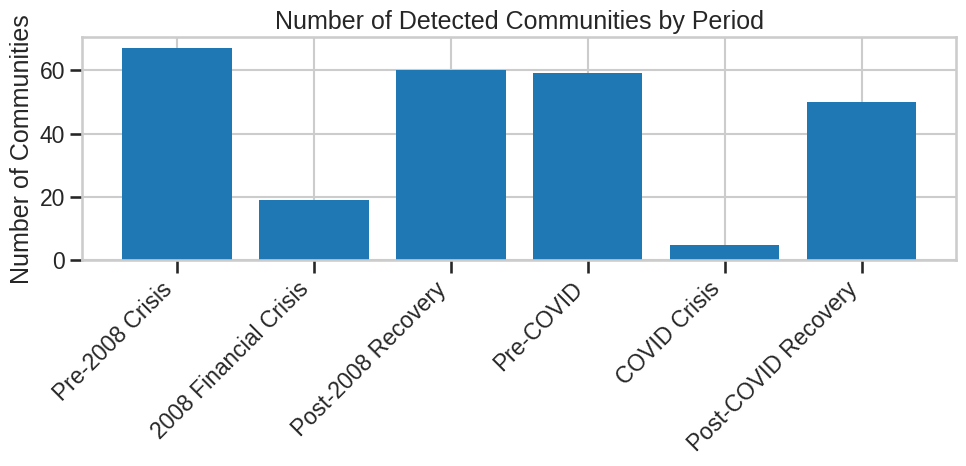

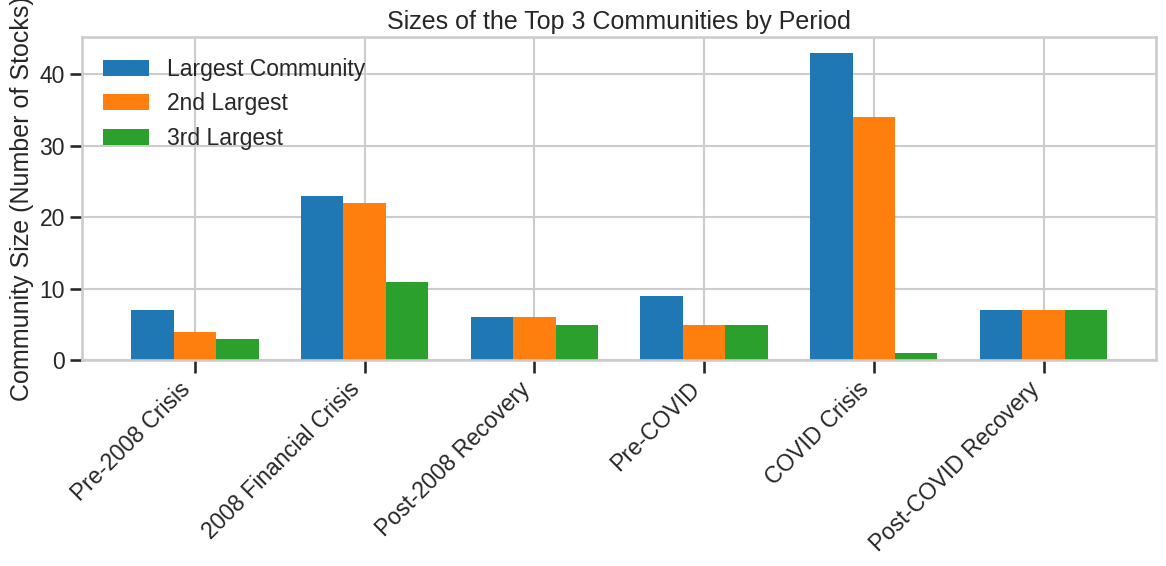

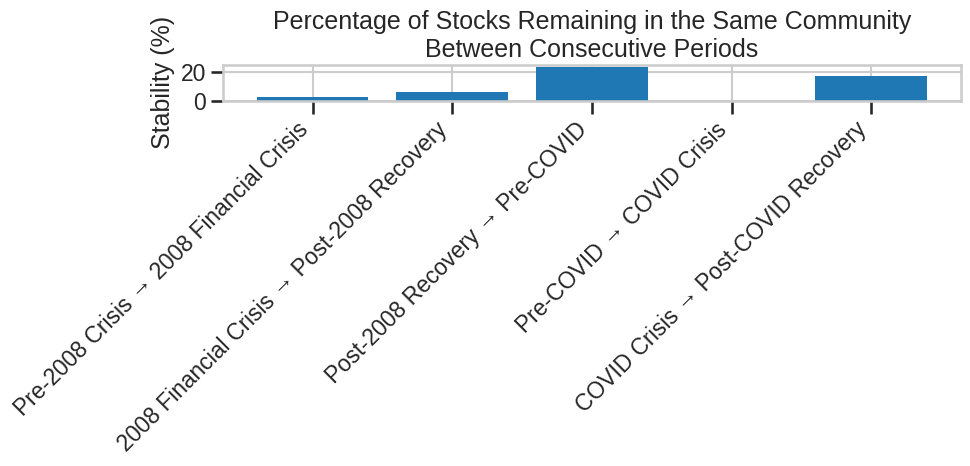

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Bar chart: Number of communities per period
plt.figure(figsize=(10, 5))
plt.bar(summary_df.index, summary_df['Num_Communities'])
plt.xticks(rotation=45, ha='right')
plt.title('Number of Detected Communities by Period')
plt.ylabel('Number of Communities')
plt.tight_layout()
plt.show()

# Grouped bar chart: Top 3 community sizes per period
x = np.arange(len(summary_df.index))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, summary_df['Top1_size'], width, label='Largest Community')
plt.bar(x,          summary_df['Top2_size'], width, label='2nd Largest')
plt.bar(x + width,  summary_df['Top3_size'], width, label='3rd Largest')

plt.xticks(x, summary_df.index, rotation=45, ha='right')
plt.title('Sizes of the Top 3 Communities by Period')
plt.ylabel('Community Size (Number of Stocks)')
plt.legend()
plt.tight_layout()
plt.show()

# Bar chart: Stability between consecutive periods
labels = stab_df['From'] + ' → ' + stab_df['To']
plt.figure(figsize=(10, 5))
plt.bar(labels, stab_df['Stable_pct'])
plt.xticks(rotation=45, ha='right')
plt.title('Percentage of Stocks Remaining in the Same Community\nBetween Consecutive Periods')
plt.ylabel('Stability (%)')
plt.tight_layout()
plt.show()



## Conclusion and Insights

After walking through our correlation networks, here’s what we learned:

1. **Crisis vs. Calm**  
   - In the **2008 crash** and **COVID-19 sell-off**, the market web got *extremely* dense—over 15% (2008) and 34% (COVID) of all possible links lit up (|corr| ≥ 0.7). Nearly every stock moved together, forming one giant cluster.  
   - In **stable periods**, density fell below 1% and the biggest group included less than 10% of tickers. Stocks broke into small, sector-specific cliques.

2. **Sector Patterns**  
   - **Energy** and **Financials** consistently formed tight groups, even outside crises—useful for anyone thinking about diversification within those industries.  
   - **Technology** names (AAPL, MSFT, NVDA…) flexed more: they spiked together during stress but then drifted apart in recoveries.  
   - **Defensive sectors** (Utilities, Consumer Staples, Healthcare) tended to stay more isolated, making them potential anchors when the rest of the market goes haywire.

3. **Key Players**  
   - During crises, certain stocks like **CSCO** (2008) and **AXP/BAC** (COVID) popped up as central “hubs” with the highest degree centrality. Keeping an eye on these hub tickers could offer early warning that correlations are shifting.

4. **What This Means**  
   - **Investors** can track network density or component size as a simple stress indicator—when density crosses a threshold, it might be time to reassess diversification.  
   - **Portfolio managers** can spot which sectors or individual names are most responsible for market-wide cohesion.  
   - **Researchers** can extend this framework with alternative correlation measures, community-detection algorithms, or live dashboards.

Overall, turning rolling correlations into networks gave us a clear, visual, and numeric way to see exactly how market cohesion tightens in downturns and loosens in recoveries—insights that go well beyond a static heatmap.


## Future Work

Here are a few directions we can explore to deepen and expand this analysis:

1. **Widen the data universe**  
   - Pull in additional equities or entire indices (e.g., small-cap, international markets).  
   - Add other asset classes—bonds, commodities, FX—to see cross-asset linkages.  
   - Extend our date range to cover more cycles (dot-com bust, 2022 volatility, etc.).

2. **Dive deeper into network theory**  
   - Run community-detection (e.g., Louvain, Girvan–Newman) to uncover hidden stock clusters.  
   - Track dynamic metrics (e.g., evolving modularity, centralization) over rolling windows.  
   - Build simple machine-learning models that use network features (density, hub scores) to predict future volatility.

3. **Build interactive dashboards**  
   - Add a time slider so users can scrub through dates and watch the network morph.  
   - Surface real-time alerts when density or hub centrality crosses critical thresholds.  
   - Let users click on a node to drill into that stock’s rolling correlations or sector links.

4. **Experiment with alternative correlation methods**  
   - Swap Pearson for non-linear measures (Spearman, Kendall, distance correlation).  
   - Explore time-frequency tools (wavelet coherence) to capture transient links.  
   - Incorporate tail-dependency metrics (copulas, extreme value theory) to focus on crash-period behavior.
